### Predicting Bike-Sharing need in Metropolitan Area


Programming Language: R 3.6.3 in Jupyter Notebook

R Libraries used:

- car
- caret
- gbm
- GGally
- ggplot2
- lubridate
- Metrics
- olsrr
- randomForest
- tidyverse


## Table of Contents

* [1. Introduction](#sec_1)
* [2. Data Exploration](#sec_2)
* [3. Exploratory Data Analysis](#sec_3)
* [4. Methodology](#sec_4)
* [5. Model Development](#sec_5)
    * [5.1. Multiple Linear Regression](#sec_5_1)
    * [5.2. Gradient Boosing Machine](#sec_5_2)
    * [5.3. Random Forest](#sec_5_3)
* [6. Inference](#sec_6)
* [7. Results and discussion](#sec_7)
* [8. Conclusion](#sec_8)
* [9. References](#sec_9)



## 1. Introduction <a class="anchor" id="sec_1"></a>

In this notebook two different models for prediction and inference regarding the number of bikes rented out in a given hour at a bike rental in Seoul are developed. The data consists mainly of weather data (temperature, humidity, wind speed, rain etc.) as well as some qualitative variables, like whether the rental company operates, whether there is a holiday etc, and of course our target variable, the rented bike count.

We will first explore the data, in order to gain a better understanding of it. For that purpose some visualisation tools will be used. Afterwards, three types of models will be developed: A multiple linear regression, a Gradient Boosing Machine and a Random Forest.

For the linear regression we will look at correlation between variabeles as well as outliers and high leverage points. We will then perform some transformation and interaction. In the end we will run a stepwise selection.

For the Gradiant Boosting machine we will use a hyperparameter grid in order to find the best combination of parameters. The Random Forest will be mainly used for the inferrence task.

After all three models have been developed we will have a look at inferrence. This will be followed by a discussion of the results of the three models and a conclusion.

## 2. Data Exploration<a class="anchor" id="sec_2"></a>

In [1]:
# surpressing warning messages
defaultW = getOption("warn") 
options(warn = -1) 

In [2]:
# Loading training and testing data
bike_train = read.csv('train.csv')
test_data = read.csv('test.csv')

After loading the train and test data we start by inspecting the dimensions of the data frame. The train data contains 17 columns and 7008 rows, the test data contains 1752 rows. There are no NA values in the data. 

In [3]:
# checking dimensions of the dataframes
dim(bike_train)
dim(test_data)

# checking for na
sum(is.na(bike_train))
sum(is.na(test_data))

# inspecting top rows of train data
head(bike_train)

[1] 7008   14

[1] 1752   14

[1] 0

[1] 0

Date     Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1 13/3/18  705               14   18.3        43       2.2        1509      
2 15/3/18  289               14   12.1        97       2.0         177      
3 29/11/18 126                5    1.8        34       0.9        1990      
4 4/4/18   378                9   10.4        81       1.4        2000      
5 15/2/18  236               17    2.4        17       3.1        1990      
6 20/4/18  708               10   18.2        36       1.0         620      
  Dew.point.temperature Solar.Radiation Rainfall Snowfall Seasons Holiday   
1   5.4                 2.43            0        0        Spring  No Holiday
2  11.6                 0.20            0        0        Spring  No Holiday
3 -12.4                 0.00            0        0        Autumn  No Holiday
4   7.2                 0.36            0        0        Spring  No Holiday
5 -20.2                 0.78            0        0        Winter  Holiday   
6   2.8                 1.99            0        0        Spring  No Holiday
  Functioning.Day
1 Yes            
2 Yes            
3 Yes            
4 Yes            
5 Yes            
6 Yes

From the information below we can see that we have a mix of integer, float and factor variables. We can also see that we have 365 levels for date, so it seems we have data for a span of one year. We will confirm this further below in our exploratory data analysis.

In [4]:
str(bike_train)

'data.frame':	7008 obs. of  14 variables:
 $ Date                 : Factor w/ 365 levels "1/1/18","1/10/18",..: 54 78 255 300 77 151 105 353 210 10 ...
 $ Rented.Bike.Count    : int  705 289 126 378 236 708 715 1001 502 17 ...
 $ Hour                 : int  14 14 5 9 17 10 8 1 20 18 ...
 $ Temperature          : num  18.3 12.1 1.8 10.4 2.4 18.2 21.1 18.9 10.7 22.2 ...
 $ Humidity             : int  43 97 34 81 17 36 70 55 70 96 ...
 $ Wind.speed           : num  2.2 2 0.9 1.4 3.1 1 0.3 2.3 2.8 1.2 ...
 $ Visibility           : int  1509 177 1990 2000 1990 620 766 2000 236 673 ...
 $ Dew.point.temperature: num  5.4 11.6 -12.4 7.2 -20.2 2.8 15.4 9.6 5.4 21.5 ...
 $ Solar.Radiation      : num  2.43 0.2 0 0.36 0.78 1.99 0.9 0 0 0.09 ...
 $ Rainfall             : num  0 0 0 0 0 0 0 0 0 3.5 ...
 $ Snowfall             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Seasons              : Factor w/ 4 levels "Autumn","Spring",..: 2 2 1 2 4 2 3 1 2 3 ...
 $ Holiday              : Factor w/ 2 levels "Holiday"

In order to make use of the date data we transform the data type into date, for both the test and train data. We then perform some feature engineering by adding month, weekday (which indicates each day of the week) and a binary variable which indicates whether it is weekend or not. In our exploratory data analysis we will see whether any of these newly created variables might influence the rented bike count.

In [5]:
#install.packages('lubridate')
library(lubridate)

# changing date from factor to date format and ordering dataframe by date

bike_train$Date = as.character(bike_train$Date)
bike_train$Date = as.Date(bike_train$Date, format="%d/%m/%Y")
bike_train = bike_train[order(bike_train$Date),]

test_data$Date = as.character(test_data$Date)
test_data$Date = as.Date(test_data$Date, format="%d/%m/%Y")
test_data = test_data[order(test_data$Date),]

# add a column for weekday and month, year not necessary because data only covers one year

bike_train$Weekday = wday(bike_train$Date, label=TRUE)
bike_train$Weekday = factor(bike_train$Weekday, ordered = FALSE)

bike_train$Month = month(ymd(bike_train$Date), label = TRUE) 
bike_train$Month = factor(bike_train$Month, ordered = FALSE)

test_data$Weekday = wday(test_data$Date, label=TRUE)
test_data$Weekday = factor(test_data$Weekday, ordered = FALSE)

test_data$Month = month(ymd(test_data$Date), label = TRUE) 
test_data$Month = factor(test_data$Month, ordered = FALSE)

head(bike_train,2)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Date       Rented.Bike.Count Hour Temperature Humidity Wind.speed
1002 0017-12-01 254               0    -5.2        37       2.2       
2071 0017-12-01  78               4    -6.0        36       2.3       
     Visibility Dew.point.temperature Solar.Radiation Rainfall Snowfall Seasons
1002 2000       -17.6                 0               0        0        Winter 
2071 2000       -18.6                 0               0        0        Winter 
     Holiday    Functioning.Day Weekday Month
1002 No Holiday Yes             Fri     Dec  
2071 No Holiday Yes             Fri     Dec

In [6]:
#add a column indicating whether it is weekend or not

weekend = c('Sat', 'Sun')
bike_train$Weekend = ifelse((bike_train$Weekday == "Sat") | (bike_train$Weekday == "Sun"), "Yes", "No")
bike_train$Weekend = factor(bike_train$Weekend, ordered = FALSE)

test_data$Weekend = ifelse((test_data$Weekday == "Sat") | (test_data$Weekday == "Sun"), "Yes", "No")
test_data$Weekend = factor(test_data$Weekend, ordered = FALSE)

head(bike_train,2)

Date       Rented.Bike.Count Hour Temperature Humidity Wind.speed
1002 0017-12-01 254               0    -5.2        37       2.2       
2071 0017-12-01  78               4    -6.0        36       2.3       
     Visibility Dew.point.temperature Solar.Radiation Rainfall Snowfall Seasons
1002 2000       -17.6                 0               0        0        Winter 
2071 2000       -18.6                 0               0        0        Winter 
     Holiday    Functioning.Day Weekday Month Weekend
1002 No Holiday Yes             Fri     Dec   No     
2071 No Holiday Yes             Fri     Dec   No

When inspecting the structure of the dataframe again we can now see that the date has changed to type date and the variables month, weekday and weekend have been added as factors.

In [7]:
str(bike_train)

'data.frame':	7008 obs. of  17 variables:
 $ Date                 : Date, format: "0017-12-01" "0017-12-01" ...
 $ Rented.Bike.Count    : int  254 78 204 600 555 426 463 484 449 100 ...
 $ Hour                 : int  0 4 1 19 17 20 15 16 12 5 ...
 $ Temperature          : num  -5.2 -6 -5.5 0 0.8 -0.3 2.1 1.2 1.7 -6.4 ...
 $ Humidity             : int  37 36 38 77 58 79 36 54 23 37 ...
 $ Wind.speed           : num  2.2 2.3 0.8 1.7 1.6 1.5 3.2 4.2 1.4 1.5 ...
 $ Visibility           : int  2000 2000 2000 2000 2000 1913 2000 793 2000 2000 ...
 $ Dew.point.temperature: num  -17.6 -18.6 -17.6 -3.5 -6.5 -3.5 -11.4 -7 -17.2 -18.7 ...
 $ Solar.Radiation      : num  0 0 0 0 0.08 0 0.54 0.24 1.11 0 ...
 $ Rainfall             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Snowfall             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Seasons              : Factor w/ 4 levels "Autumn","Spring",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Holiday              : Factor w/ 2 levels "Holiday","No Holiday": 2 2 2 2 2 2 2 2 2 2 ...
 $ 

## 3. Exploratory Data Analysis<a class="anchor" id="sec_3"></a>

We will now perform some Exploratory Data Analysis in order to get more familiar with the data and to see whether there are any patterns in the data which could be useful to make inference about which variables influence the rental bike count the most. 

In [8]:
summary(bike_train)

      Date            Rented.Bike.Count      Hour        Temperature    
 Min.   :0017-12-01   Min.   :   0.0    Min.   : 0.00   Min.   :-17.50  
 1st Qu.:0018-03-02   1st Qu.: 188.0    1st Qu.: 5.75   1st Qu.:  3.40  
 Median :0018-05-31   Median : 503.0    Median :11.00   Median : 13.60  
 Mean   :0018-06-01   Mean   : 703.2    Mean   :11.46   Mean   : 12.83  
 3rd Qu.:0018-09-01   3rd Qu.:1063.0    3rd Qu.:17.00   3rd Qu.: 22.50  
 Max.   :0018-11-30   Max.   :3556.0    Max.   :23.00   Max.   : 39.40  
                                                                        
    Humidity       Wind.speed     Visibility     Dew.point.temperature
 Min.   : 0.00   Min.   :0.00   Min.   :  27.0   Min.   :-30.600      
 1st Qu.:42.00   1st Qu.:0.90   1st Qu.: 944.8   1st Qu.: -4.700      
 Median :57.00   Median :1.50   Median :1693.0   Median :  5.000      
 Mean   :58.25   Mean   :1.72   Mean   :1436.0   Mean   :  4.029      
 3rd Qu.:74.00   3rd Qu.:2.30   3rd Qu.:2000.0   3rd Qu.: 14.

**Obervations looking at summary statistics:**

The data contains bike rental information from 01/12/2017 to 30/11/2018, so exactly one year. The median for bike rentals is around 500 per hour, and the mean around 700 per hour. The temperature goes from very cold (almost -20 degrees) to very hot (almost 40 degrees). When looking at weekdays, we can see that Friday and Sunday have the highest occurence. This might be because of night hour rentals. When looking at the summary statistics we can observe some possible issues with outliers. We will explore this topic further when having a look at influence points.

Possible issues:

* Is the maximum bike count an outlier? 3556 seems very high when looking at mean and median which are around 700 and 500 respectively. Maybe there was a big event happening in the city and thus much more people rented a bike


* Humidity has as min 0 but at least when talking about absoulte humidity this is not possible. Might refer to relative humidity where zero is possible? (Chandler 2001) 



* Solar radiation max seems extremely high when looking at median and mean. However, given that the rental company rents out bikes througout the night it might explain the low mean and median for radiation. Over the course of a year roughly 12 hours per day in average have zero solar radiation


* The maximum for rain seems also very high when looking at median and mean. This might come from the months of July and August where Seoul experiences much more rainfall than in the rest of they year.

We can see from the above plot below that there is a clear seasonal trend, with winter having the least amount of bike rentals and the summer most.

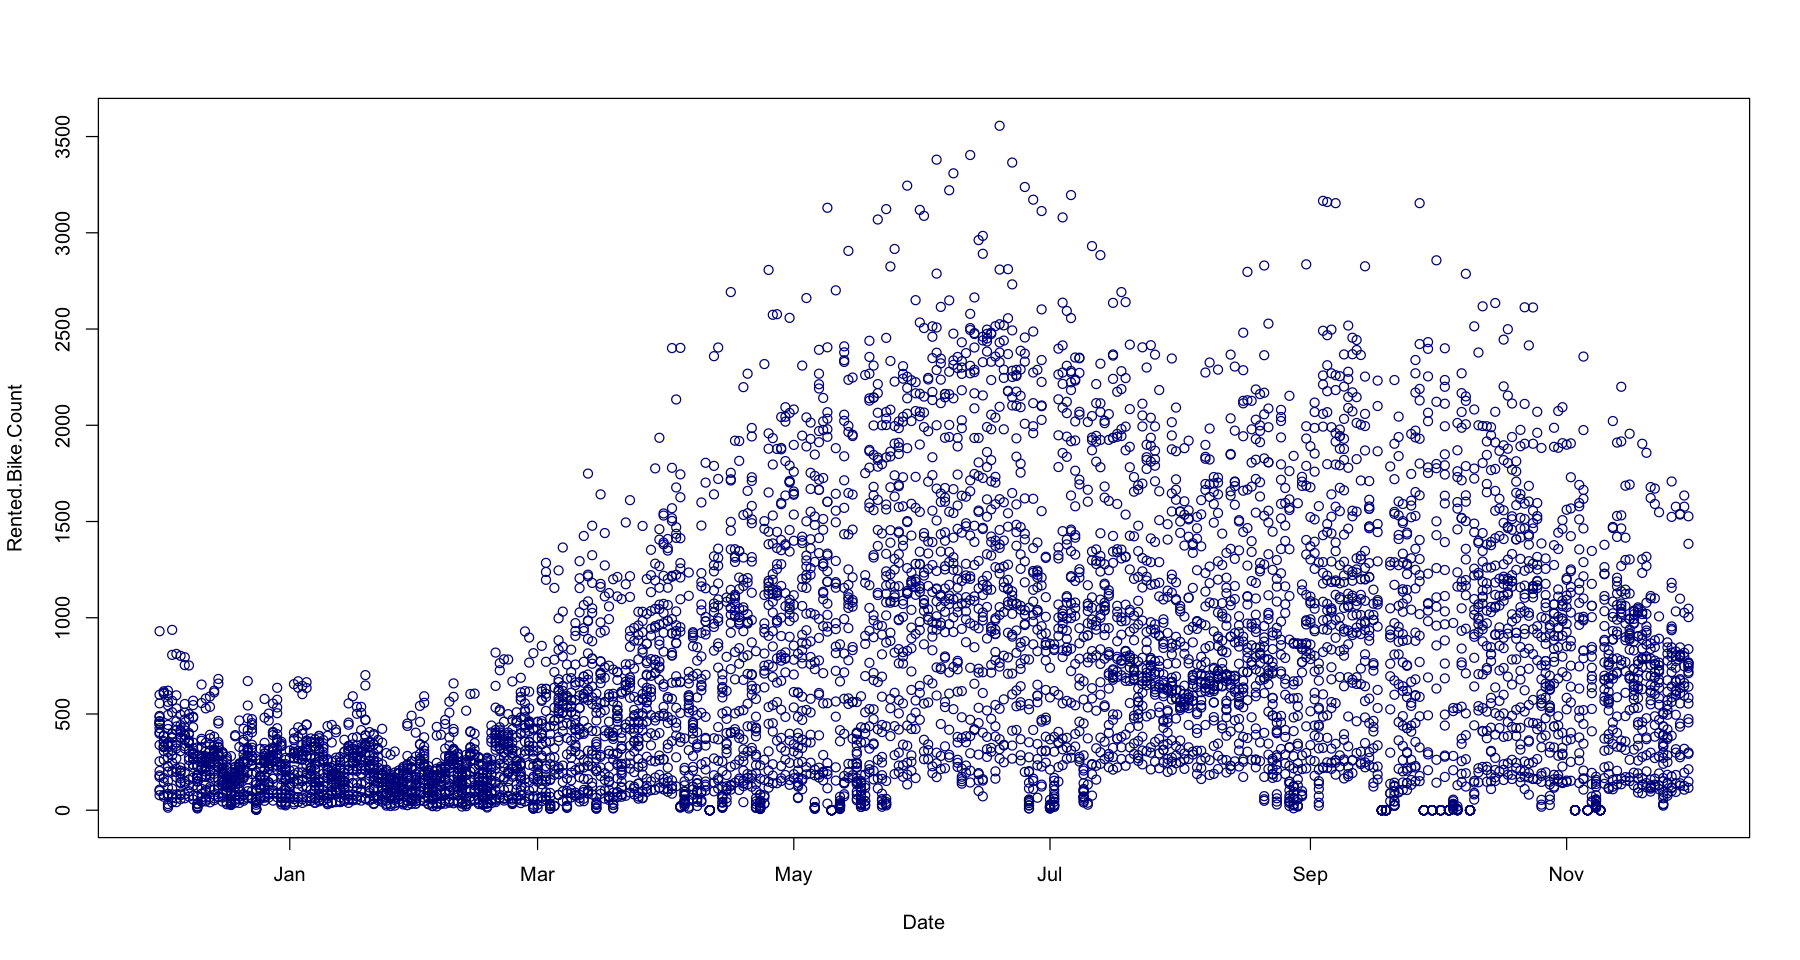

In [9]:
options(repr.plot.width=15, repr.plot.height = 8)
plot(Rented.Bike.Count ~ Date, bike_train, col = 'darkblue')

We can see from the boxplots below that the day of the week does not seem to be significant in determining the number of bikes rented on a given day as there is not much of a difference in the boxplots (the medians are fairly similar and even the IQR does not show big differences). However, it's worthwhile to check whether there are any differences between weekend and weekday when we look at the hourly data. This is explored further below. We can also observe that there are outliers for each day of the week above the upper whisker.

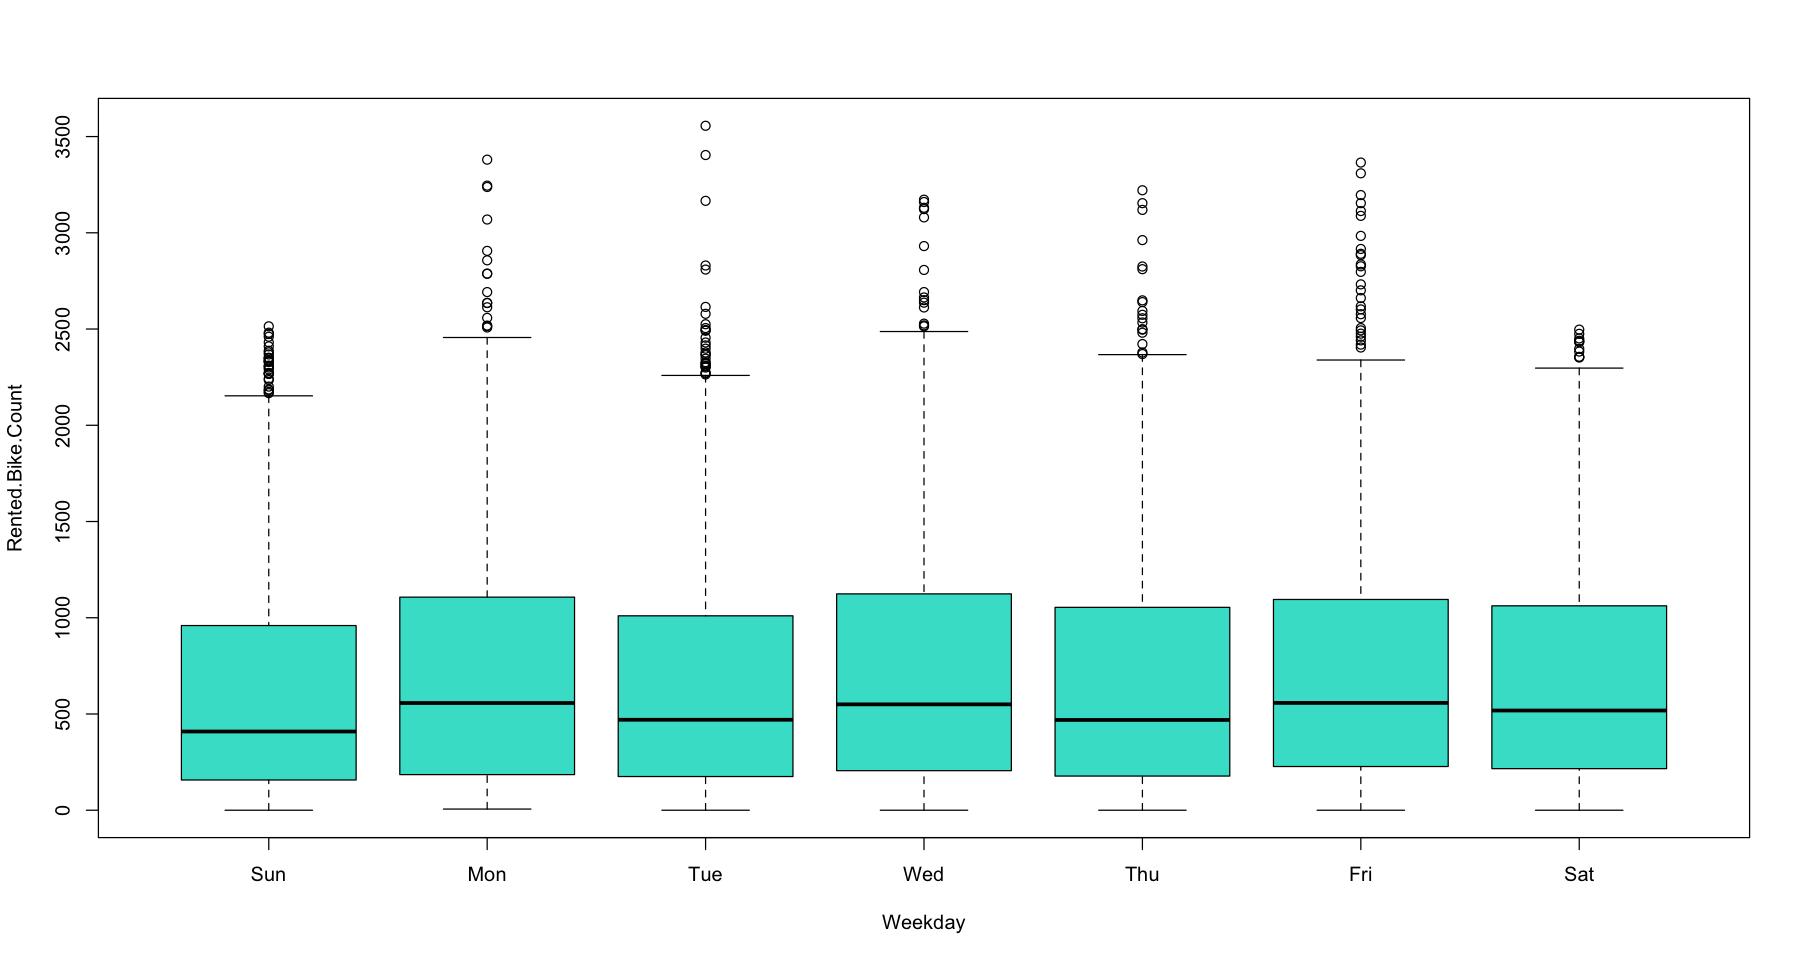

In [10]:
boxplot(Rented.Bike.Count ~ Weekday, bike_train, col = 'turquoise')

Interestingly, even though there is no significant overall difference in the bikes rented on a given weekday, the picture changes if we look at hourly data. Here we can see that the demand for bikes during the week looks very different to the one on the weekend. During the week we see peeks during rush hour (people going and coming from work), whereas we cannot see the same trend on the weekend. On the weekend the demand is less during peek hours than during the week, however at most other hours of the day the demand is higher (in the middle of the night and the afternoon). So having a column indicating whether it is weekday or weekend seems plausible for our model building.

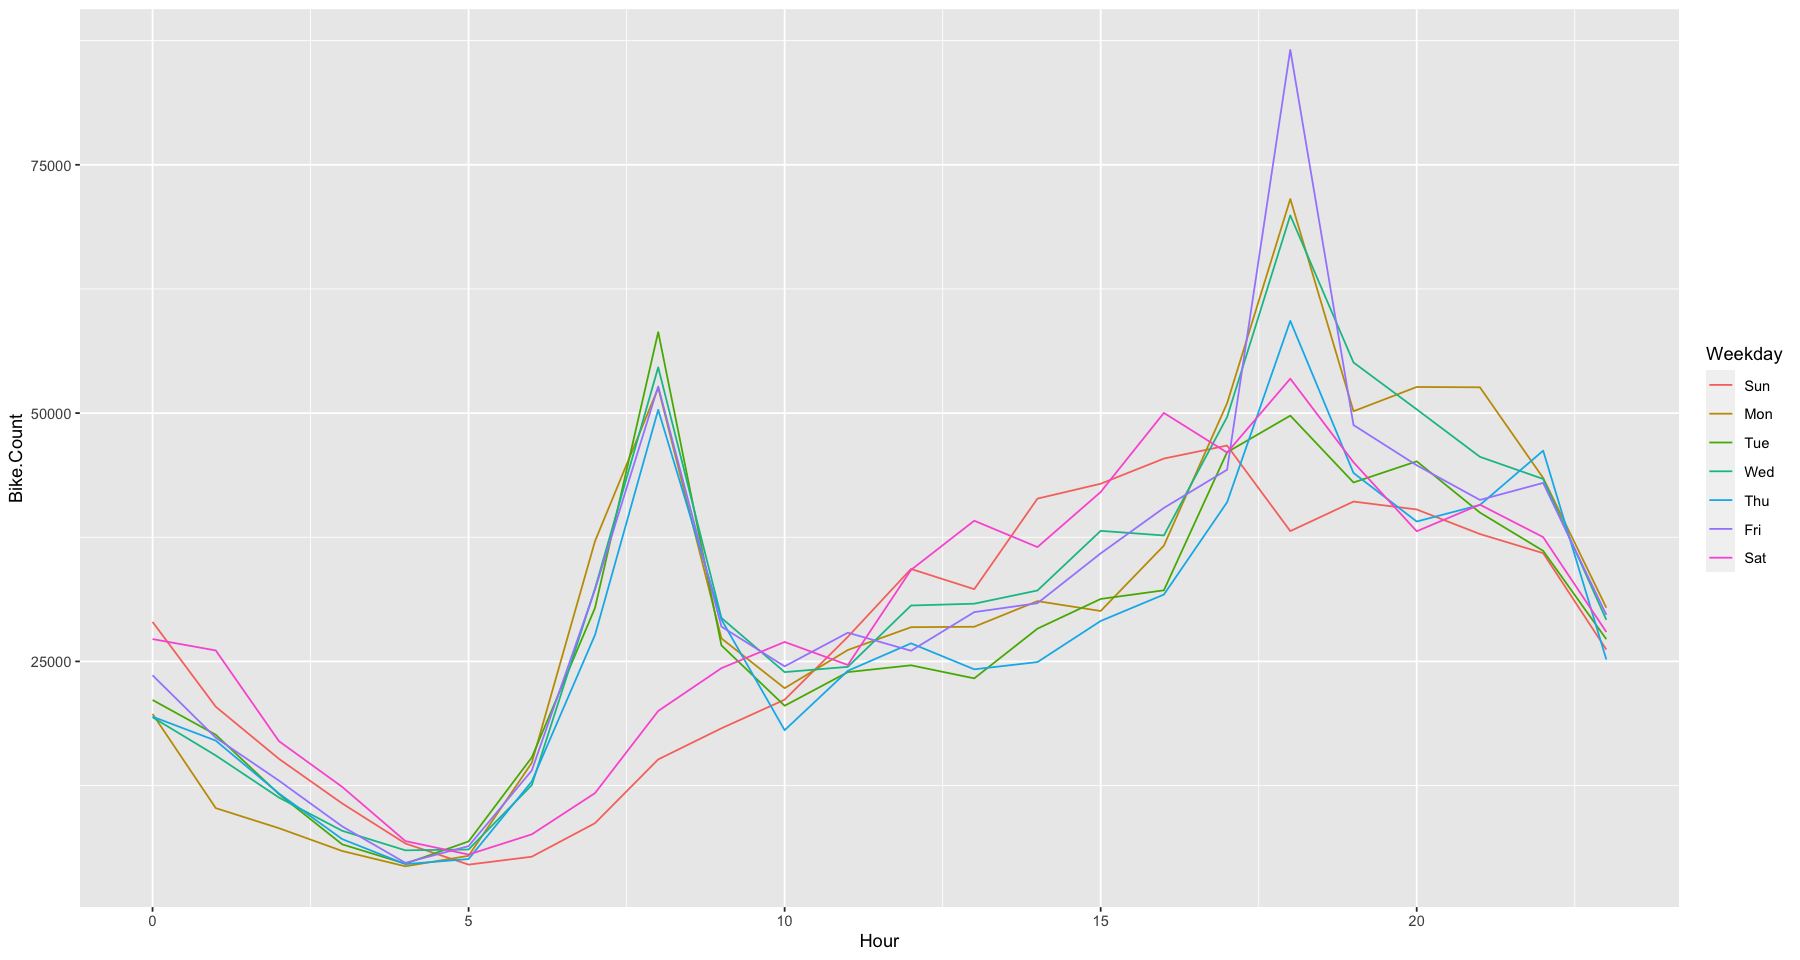

In [11]:
library(ggplot2)

grouped_hour_day = aggregate(bike_train$Rented.Bike.Count,
                             by=list(Category=bike_train$Hour,
                                    bike_train$Weekday), FUN=sum)

col_names = c("Hour", "Weekday", "Bike.Count")

names(grouped_hour_day) = col_names

ggplot(grouped_hour_day, aes(x = Hour, y = Bike.Count, colour = Weekday, group = Weekday)) +
geom_line()



From the graph below we can see that the hourly trend remains throughout all months of the year but is not as drastic in the winter months.

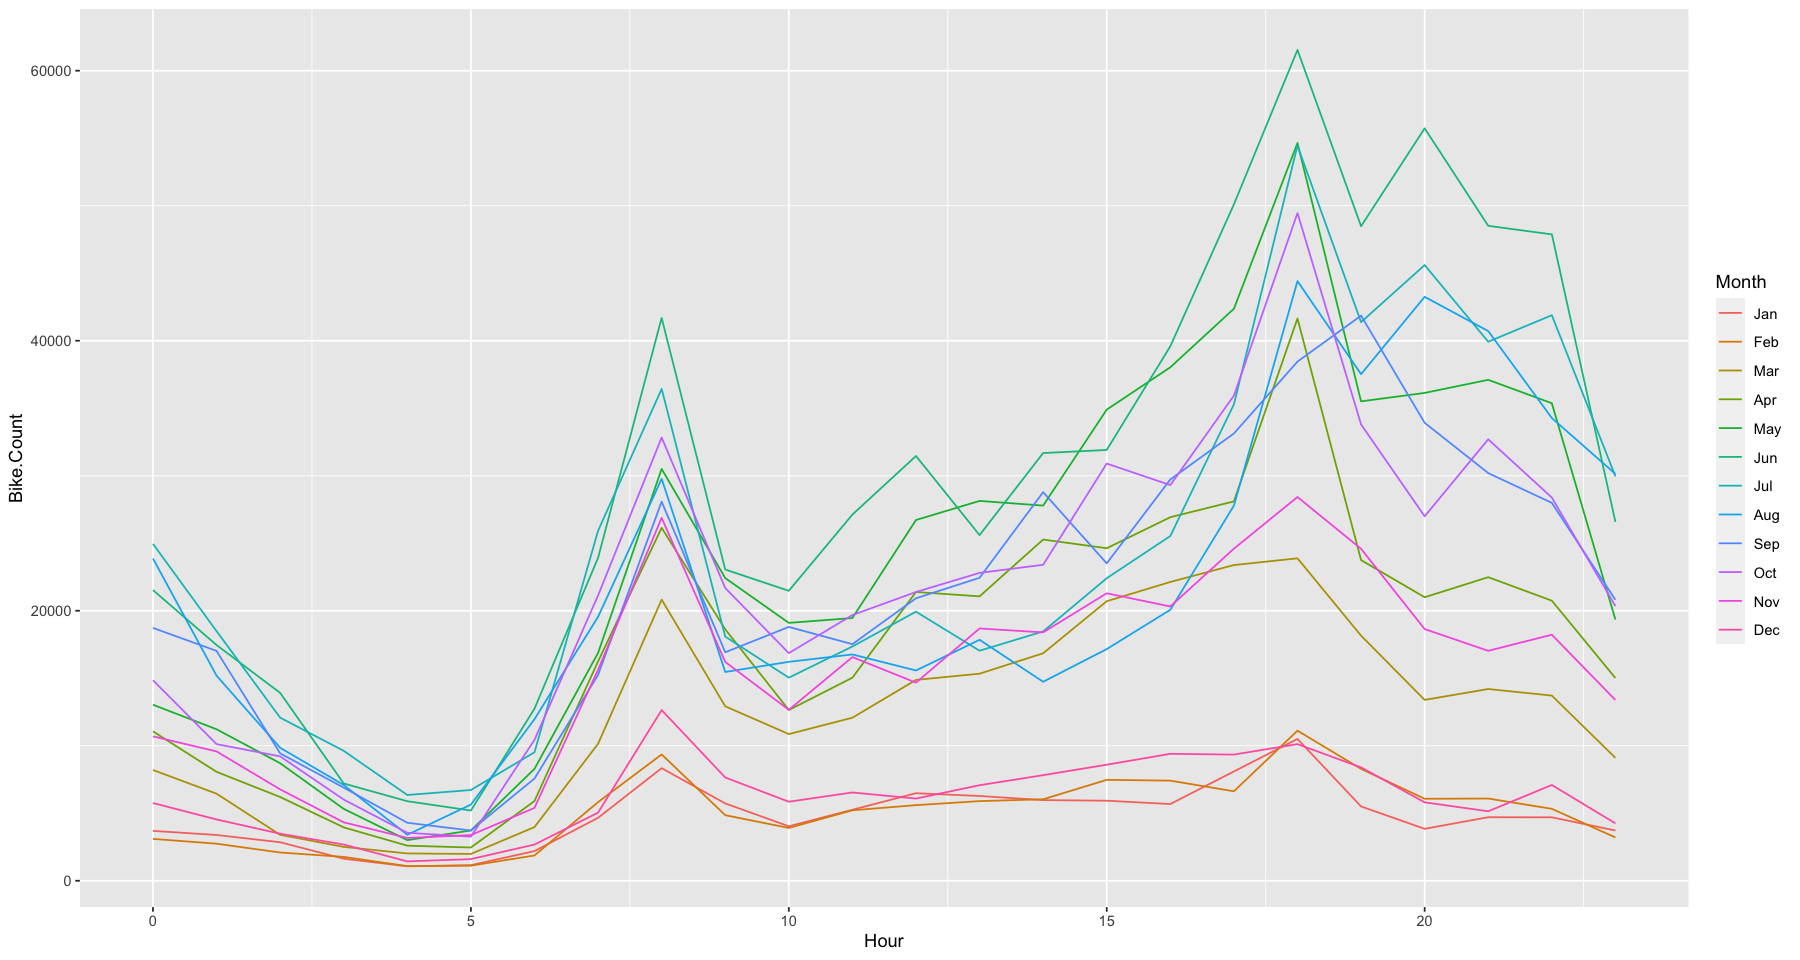

In [12]:
grouped_hour_months = aggregate(bike_train$Rented.Bike.Count,
                             by=list(Category=bike_train$Hour,
                                    bike_train$Month), FUN=sum)

col_names = c("Hour", "Month", "Bike.Count")

names(grouped_hour_months) = col_names

ggplot(grouped_hour_months, aes(x = Hour, y = Bike.Count, colour = Month, group = Month)) +
geom_line()

As we could see from the plot further above season seems to play a significant role for the number of bikes rented.

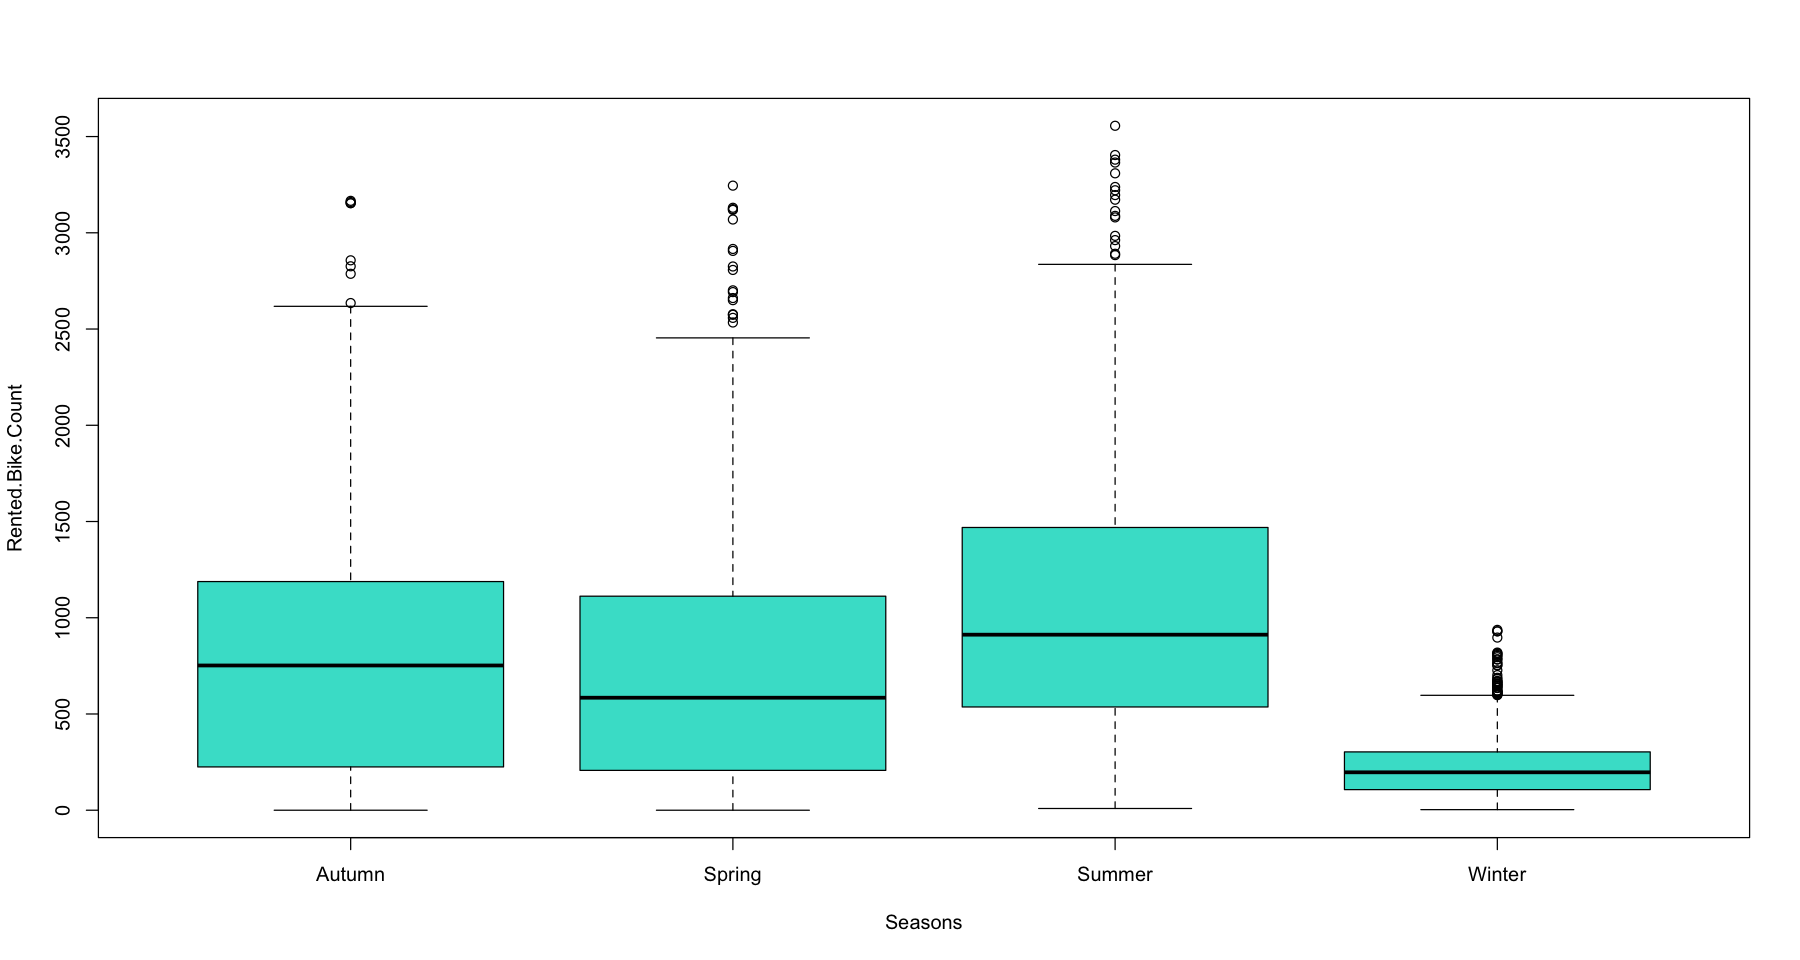

In [13]:
boxplot(Rented.Bike.Count ~ Seasons, bike_train, col = 'turquoise')

Whether there is a holiday or not also seems to play a role in determining the number of bike rented as there are more bike rentals when there is no holiday.

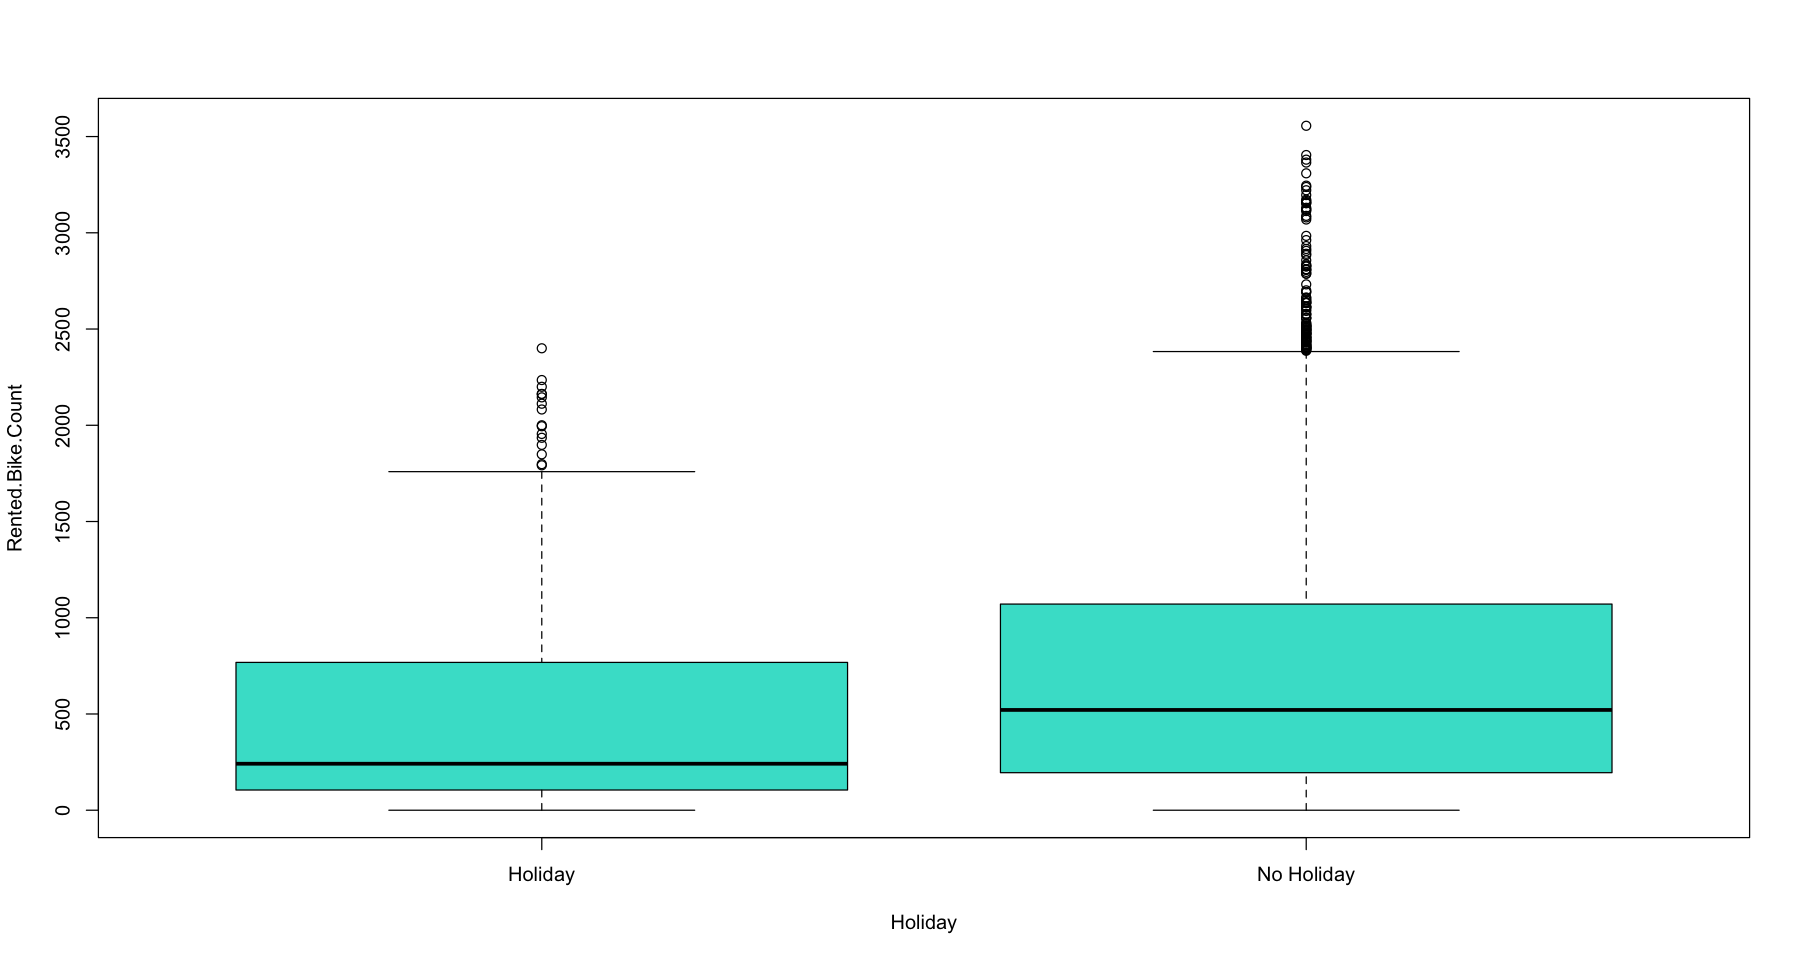

In [14]:
boxplot(Rented.Bike.Count ~ Holiday, bike_train, col = 'turquoise')

When looking at the hours of the day we can see that, as expected, the number of bikes rented is the smallest in the middle of the night and the early morning hours (between 2am and 6am). The count is the highest around 8am and between 5pm and 10pm, which is the time people are going to and from work and for example meet friends after work. Interestingly, compared to many of the other variables, there are almost no outliers for the hours.

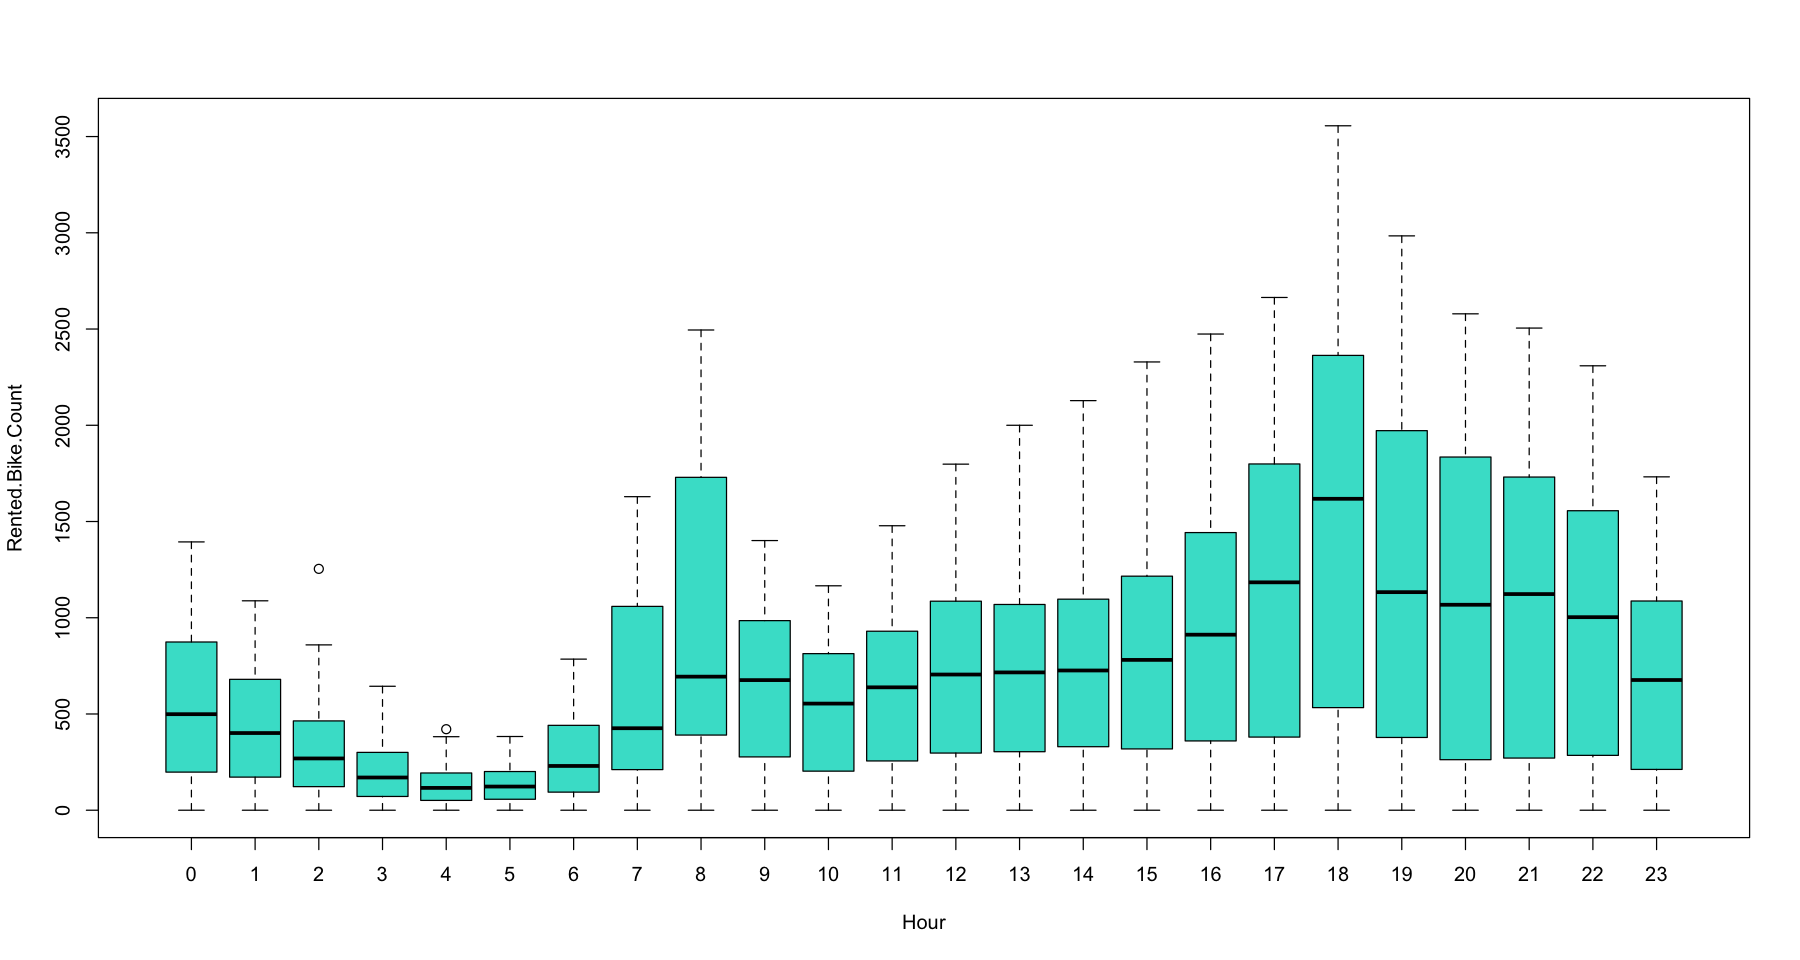

In [15]:
boxplot(Rented.Bike.Count ~ Hour, bike_train, col = 'turquoise')

When looking at the months we get a bit clearer picture of bikes rented than when we only look at the season. June is the month with the most bikes rented, followed by May and September and October. The least amount of bikes are rented in January, February and December.

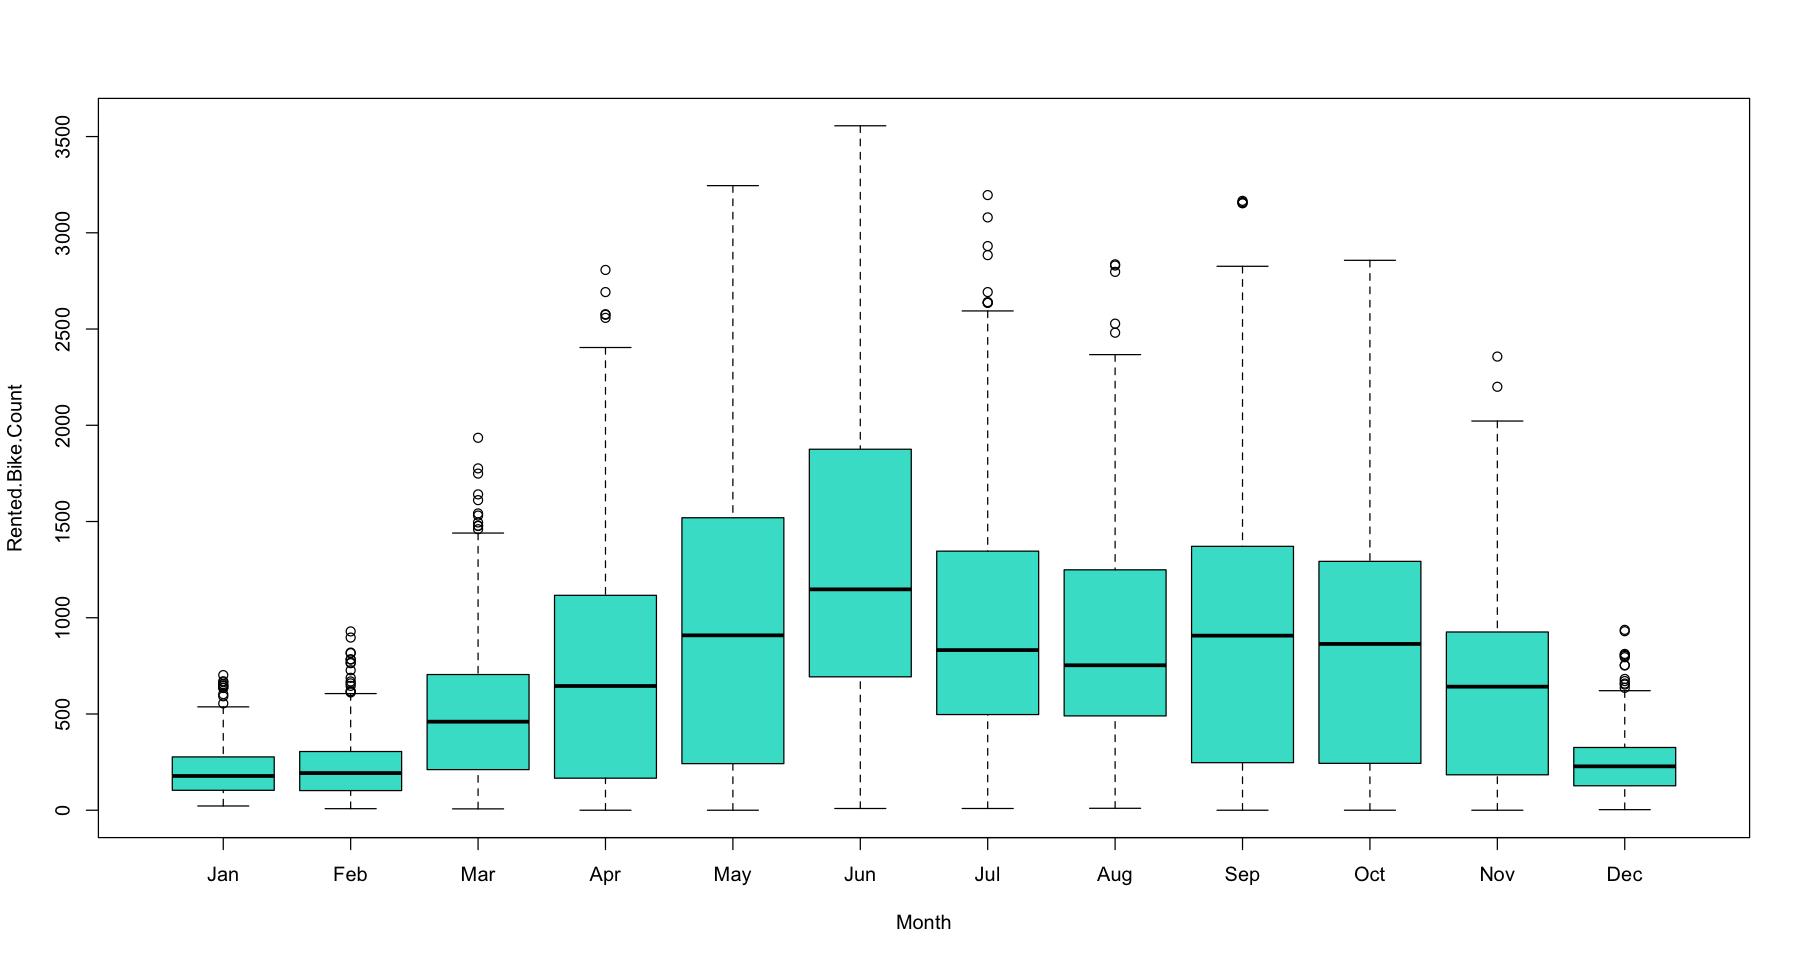

In [16]:
boxplot(Rented.Bike.Count ~ Month, bike_train, col = 'turquoise')

As expected if the bike sharing company doesn't operate, no bikes are rented out.

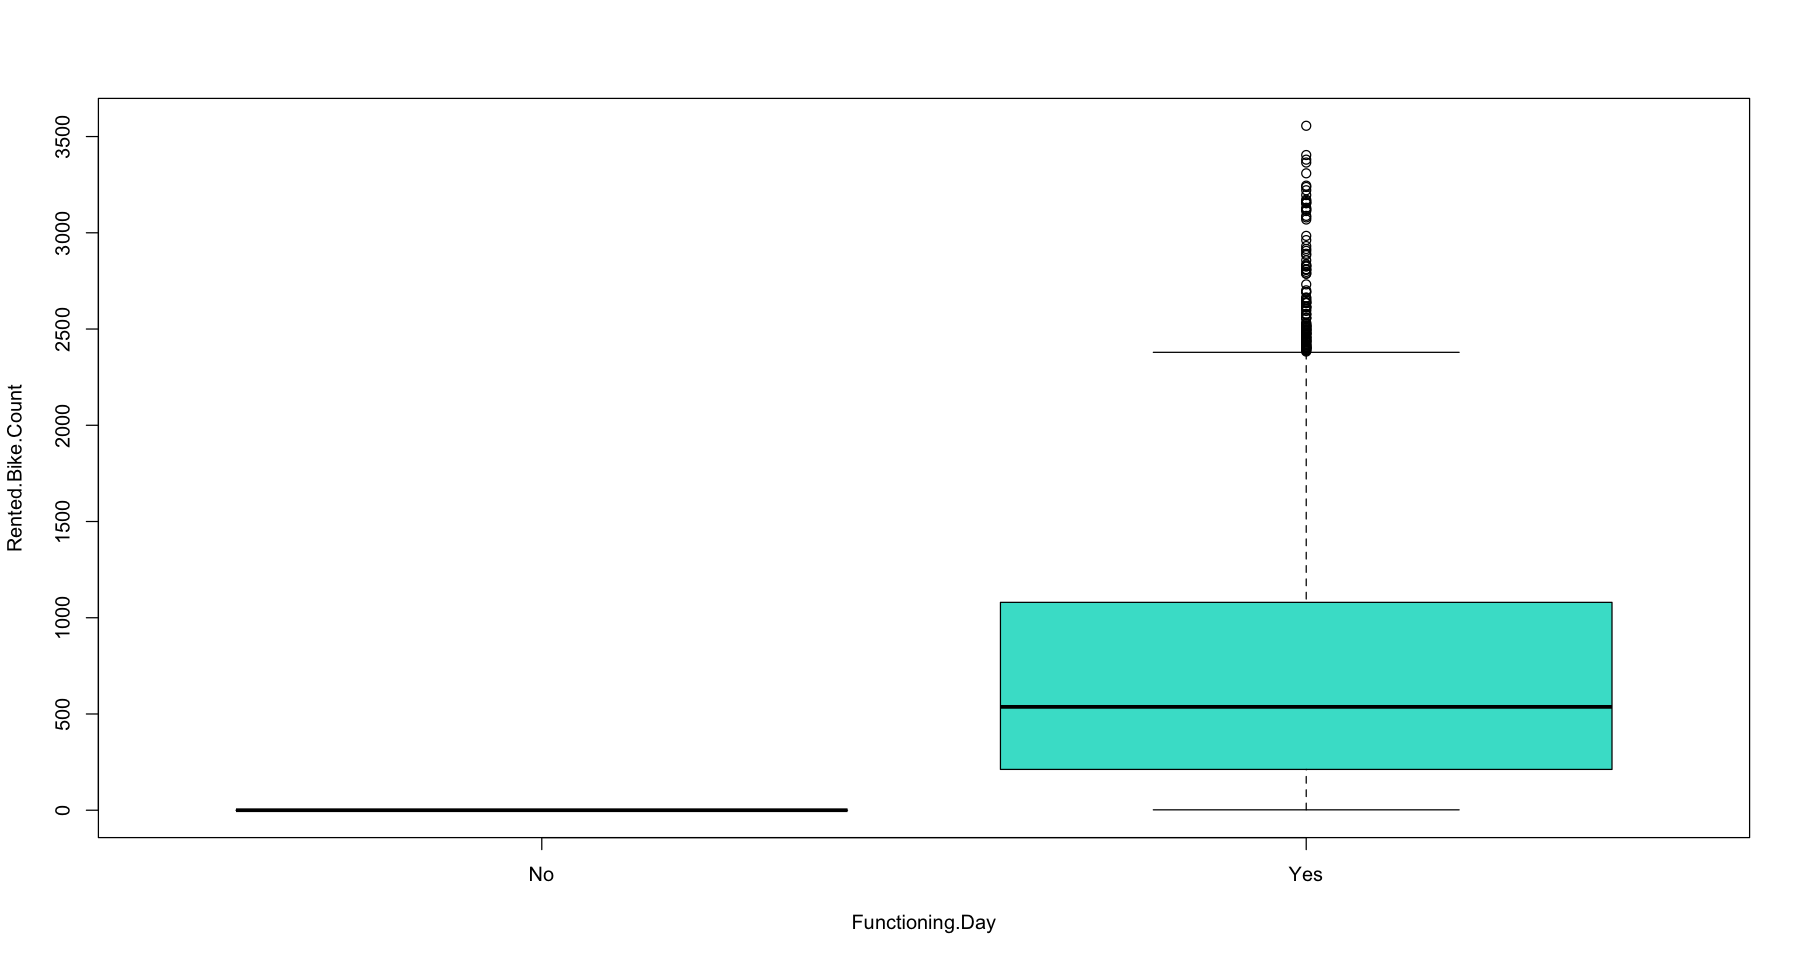

In [17]:
boxplot(Rented.Bike.Count ~ Functioning.Day, bike_train, col = 'turquoise')

The following features, which are numeric, will be examined in one graph.

In [18]:
numeric_features = bike_train[-c(1,3,12:17)]
head(numeric_features,2)


Rented.Bike.Count Temperature Humidity Wind.speed Visibility
1002 254               -5.2        37       2.2        2000      
2071  78               -6.0        36       2.3        2000      
     Dew.point.temperature Solar.Radiation Rainfall Snowfall
1002 -17.6                 0               0        0       
2071 -18.6                 0               0        0

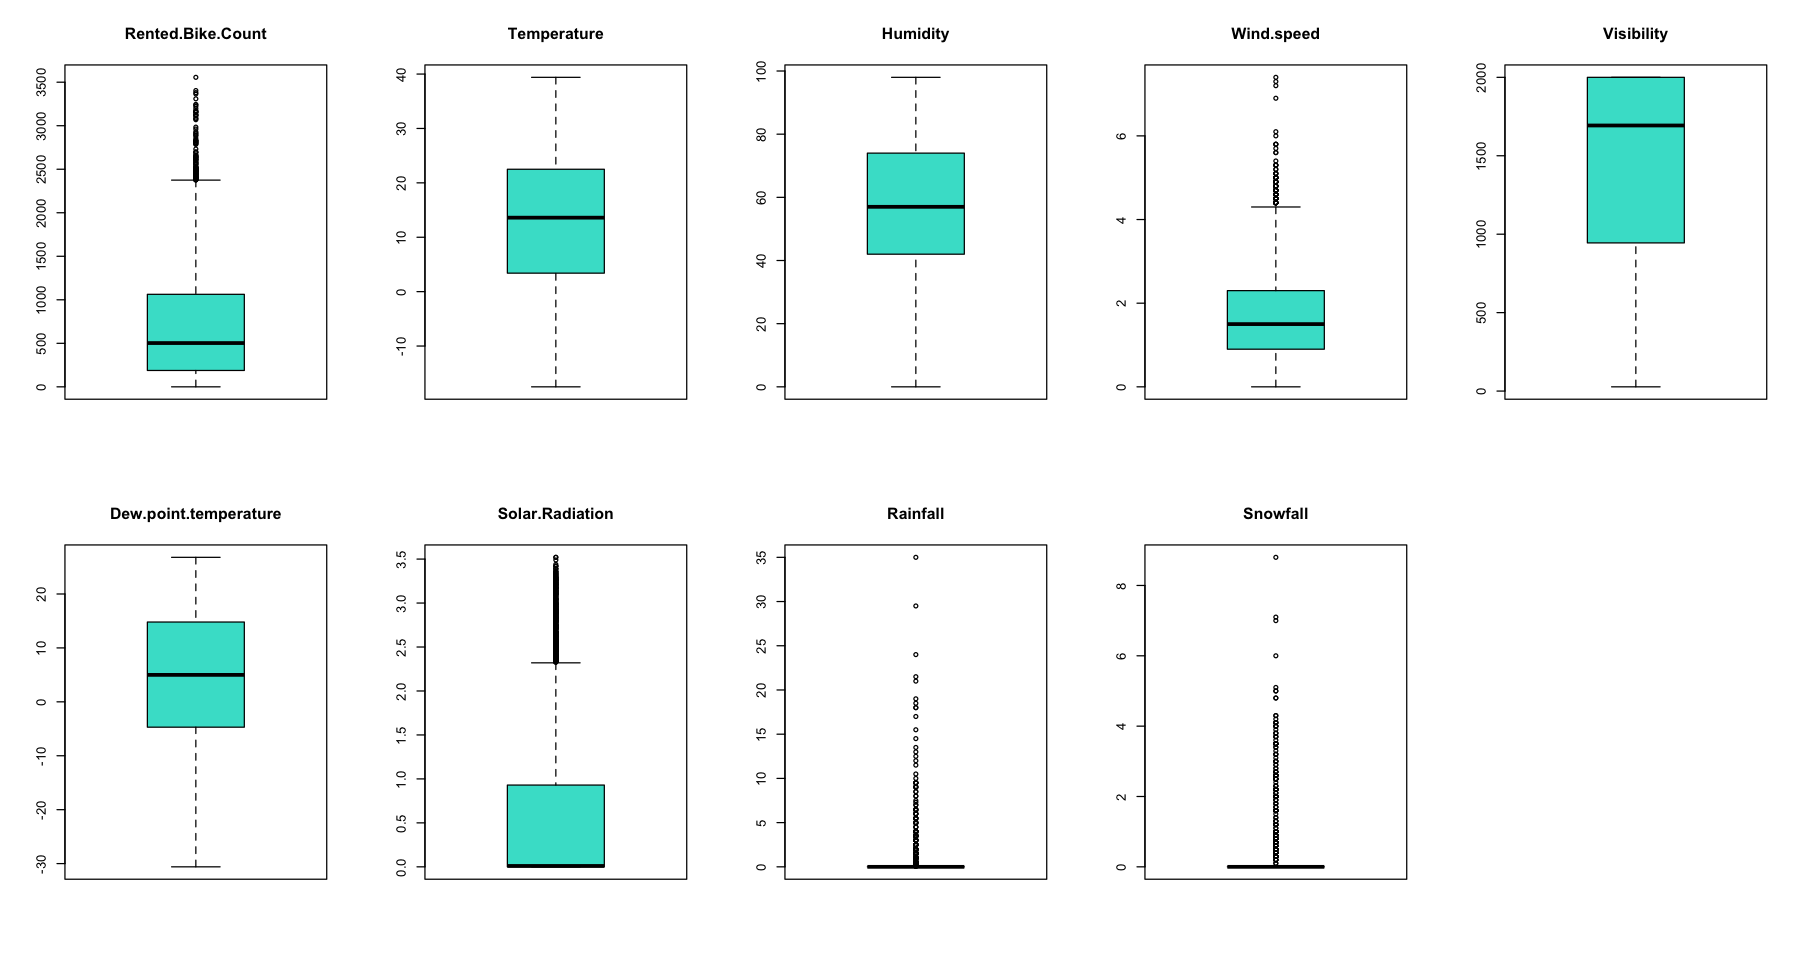

In [19]:
par(mfrow = c(2,5)) # 2 x 5 grid
options(repr.plot.width=15, repr.plot.height = 8)
for (i in 1:(length(numeric_features))) {
        boxplot(numeric_features[,i], main = names(numeric_features[i]), type="l", col = 'turquoise')}

### Correlation

Let's have a look at the correlation of the numeric features. This will be done in two ways. First a correlation table will be displayed and then the information will be shown as a correlation matrix with corresponding data of the table.

In [20]:
# correlation table
round(cor(numeric_features),2)

Rented.Bike.Count Temperature Humidity Wind.speed
Rented.Bike.Count      1.00              0.54       -0.20     0.13     
Temperature            0.54              1.00        0.16    -0.03     
Humidity              -0.20              0.16        1.00    -0.34     
Wind.speed             0.13             -0.03       -0.34     1.00     
Visibility             0.20              0.04       -0.54     0.18     
Dew.point.temperature  0.38              0.91        0.53    -0.18     
Solar.Radiation        0.26              0.35       -0.47     0.33     
Rainfall              -0.12              0.05        0.23    -0.01     
Snowfall              -0.14             -0.22        0.12    -0.02     
                      Visibility Dew.point.temperature Solar.Radiation Rainfall
Rented.Bike.Count      0.20       0.38                  0.26           -0.12   
Temperature            0.04       0.91                  0.35            0.05   
Humidity              -0.54       0.53                 -0.47            0.23   
Wind.speed             0.18      -0.18                  0.33           -0.01   
Visibility             1.00      -0.17                  0.15           -0.16   
Dew.point.temperature -0.17       1.00                  0.09            0.12   
Solar.Radiation        0.15       0.09                  1.00           -0.07   
Rainfall              -0.16       0.12                 -0.07            1.00   
Snowfall              -0.13      -0.15                 -0.07            0.01   
                      Snowfall
Rented.Bike.Count     -0.14   
Temperature           -0.22   
Humidity               0.12   
Wind.speed            -0.02   
Visibility            -0.13   
Dew.point.temperature -0.15   
Solar.Radiation       -0.07   
Rainfall               0.01   
Snowfall               1.00

In [21]:
correl_func = function(data, mapping, method="p", use="pairwise", ...){

    # get data
    x = eval_data_col(data, mapping$x)
    y = eval_data_col(data, mapping$y)

    # calculate correlation
    corr = cor(x, y, method=method, use=use)

    # colour is based on calculated correlation value, red for negative, blue 
    # for positive relation and white for inbetween

    colFn = colorRampPalette(c("red", "white", "blue"), interpolate ='spline')
    fill = colFn(100)[findInterval(corr, seq(-1, 1, length=80))]

    ggally_cor(data = data, mapping = mapping, ...) + 
    theme_void() +
    theme(panel.background = element_rect(fill=fill))
    }

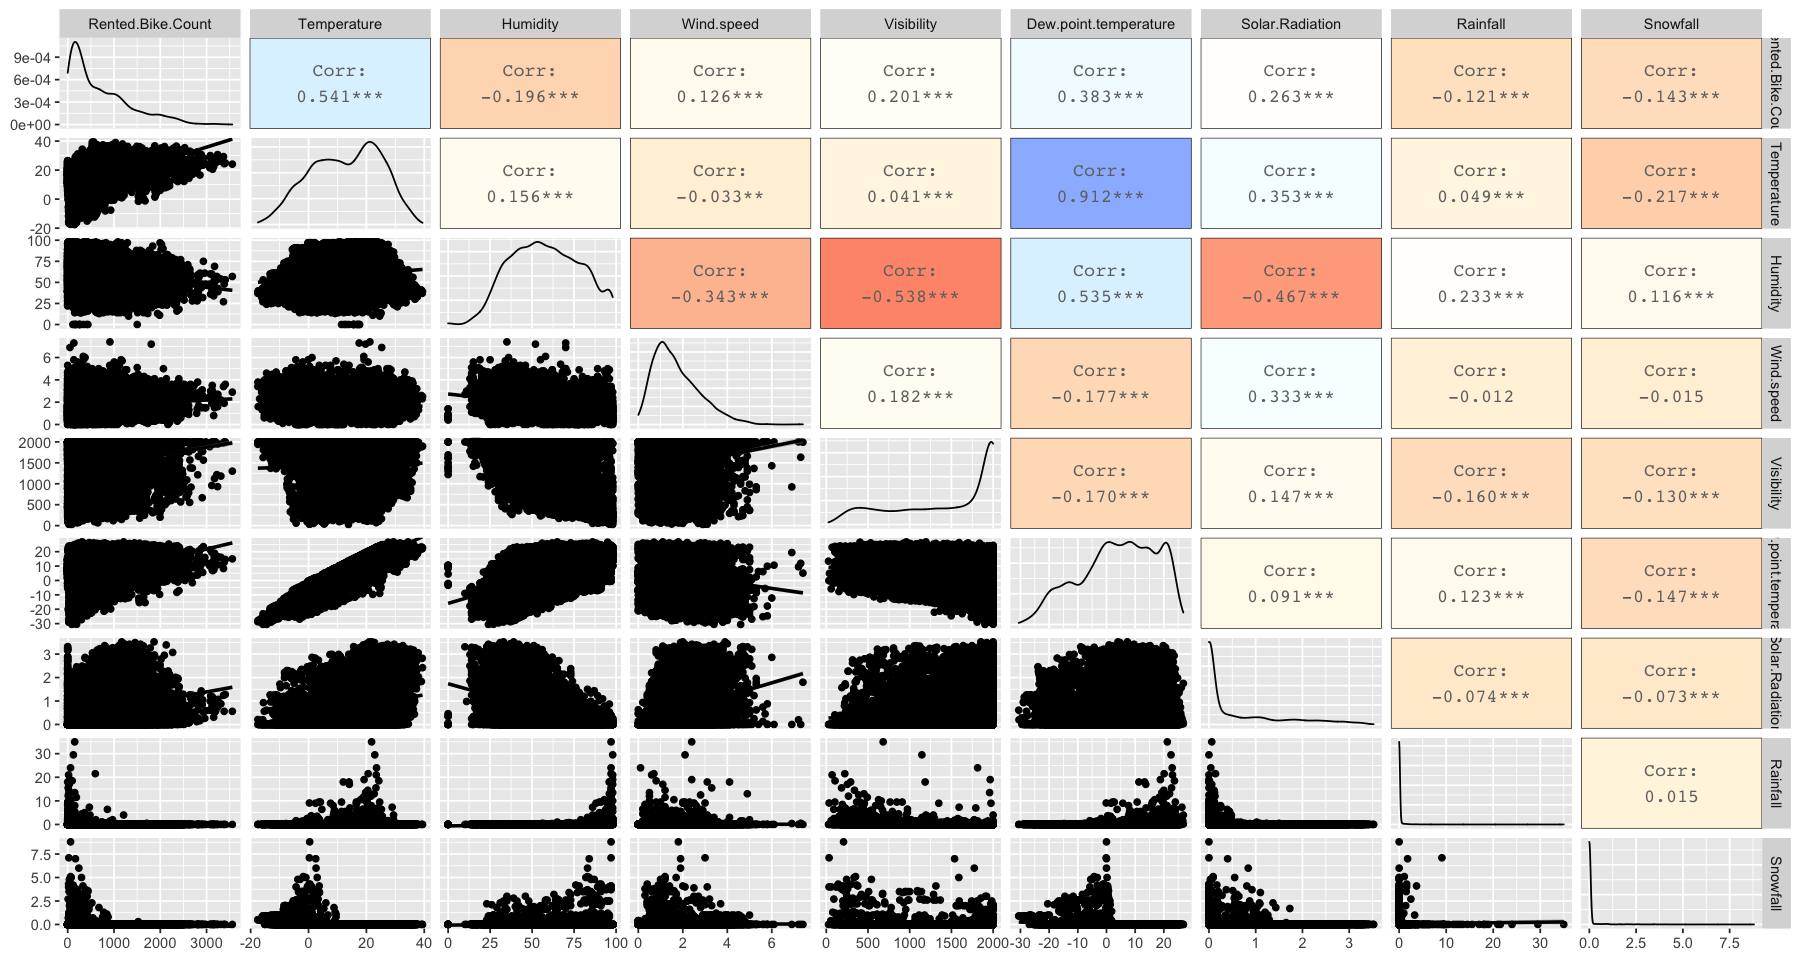

In [70]:
library(GGally) 
options(repr.plot.width=15, repr.plot.height = 8)
correlation_plot = ggpairs(numeric_features, 
                   upper = list(continuous = correl_func),
                   lower = list(continuous = "smooth")) 

correlation_plot

**Observations from correlation matrix and table**

We can see that temperature and dew point temperature are highly correlated (0.91). Rented bike count seems to have the highest correlation with temperature (0.54) out of all variables. This means that generally speaking the higher the temperature, the more bikes will be rented out. No further moderate or strong correlations can be observed between bike count and the other features. Bike count seems to be weekly correlated with dew point temperature which is not surprising given the correlation of the two temperature features. We can further observe that Visibility and Solar Radiation are moderately negatively related with humidity.


Since having strong correlations between predictive variables can be problematic, Dew.point.temperature will be removed from the data.

## 4. Methodology<a class="anchor" id="sec_4"></a>

In order to predict the number of bikes rented for a given hour, two models will be developed. The first one is a multiple linear regression which takes the form of:

Y = $\beta_0 + \beta_1X_1 + \beta_2X_2 \; ... \; + \beta_pX_p + \epsilon$

where $\beta_0$ is the intercept and the remaining betas quantify the replationship between the specific variable and the output. 

We will inspect whether the relationship between the predictors and the output can assumed to be linear and perform some adjustments to create a better fit. The model will be evaluated with the RMSE, which penalizes values far off the actual value more than the MAE does.

The second model which will be developed is a Gradient Boosting machine. GBM make use of weak learners and improve them in small steps in many iterations to make the stronger. Thus, they learn from the errors of the previous iterations. In order to find the best model, a hyperparameter grid will be deployed which will return the most suitable values for each hyperparameter for the model while making use of a hold out set of the data. The estimated RMSE will then be calculated with a 10 fold cross validation.

Further, a Random Forest will be developed, however, this is mainly done for the inference task.

## 5. Model Development <a class="anchor" id="sec_5"></a>

### 5.1 Multiple linear regression <a class="anchor" id="sec_5_1"></a>

Since we have engineered some useful data with the date, we don't need the date column on its own anymore and it will be taken out before training the model. As disccused above regarding correlation, we will also remove dew point temperature. Further, we have observed in our EDA that the day of the week does not seem to have a significant influence on the number of bikes rented, however, whether it is weekday or weekend does. So day of the week ('Weekday') will be removed, however, Weekend (yes/no) will remain in the data.

In [23]:
# Remove date, dew point temperature and weekday

bike_train2 = bike_train[,-c(1,8,15)]
head(bike_train2,2)

Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1002 254               0    -5.2        37       2.2        2000      
2071  78               4    -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Seasons Holiday    Functioning.Day Month
1002 0               0        0        Winter  No Holiday Yes             Dec  
2071 0               0        0        Winter  No Holiday Yes             Dec  
     Weekend
1002 No     
2071 No

Now where the data has been cleaned up we will train our first linear regression.

#### First Linear model

In [24]:
linear_fit = lm(Rented.Bike.Count ~ ., data = bike_train2)
summary(linear_fit)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1289.69  -267.19   -44.31   209.14  1952.43 

Coefficients: (3 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -559.06288   56.53695  -9.888  < 2e-16 ***
Hour                 26.74177    0.79703  33.552  < 2e-16 ***
Temperature          30.45701    1.30152  23.401  < 2e-16 ***
Humidity             -7.16650    0.42090 -17.027  < 2e-16 ***
Wind.speed           23.46646    5.49082   4.274 1.95e-05 ***
Visibility            0.06212    0.01230   5.052 4.49e-07 ***
Solar.Radiation     -92.73571    8.00045 -11.591  < 2e-16 ***
Rainfall            -58.42511    4.38284 -13.330  < 2e-16 ***
Snowfall             35.43629   11.87939   2.983 0.002864 ** 
SeasonsSpring        20.77809   27.99756   0.742 0.458028    
SeasonsSummer      -421.20976   39.21187 -10.742  < 2e-16 ***
SeasonsWinter      -284.07083   2

From the linear regression statistics we can see that some coefficients could not be calculated because of "singularities" which means that there might be collinearity between features. We can inspect this further by calling 'alias' which indicates strong collinearity for all non-zero matrix entries. 


In [25]:
alias(linear_fit)

Model :
Rented.Bike.Count ~ Hour + Temperature + Humidity + Wind.speed + 
    Visibility + Solar.Radiation + Rainfall + Snowfall + Seasons + 
    Holiday + Functioning.Day + Month + Weekend

Complete :
         (Intercept) Hour Temperature Humidity Wind.speed Visibility
MonthMay  0           0    0           0        0          0        
MonthAug  0           0    0           0        0          0        
MonthNov  1           0    0           0        0          0        
         Solar.Radiation Rainfall Snowfall SeasonsSpring SeasonsSummer
MonthMay  0               0        0        1             0           
MonthAug  0               0        0        0             1           
MonthNov  0               0        0       -1            -1           
         SeasonsWinter HolidayNo Holiday Functioning.DayYes MonthFeb MonthMar
MonthMay  0             0                 0                  0       -1      
MonthAug  0             0                 0                  0        0      
Mont

It is no surprise to see that some of the month are strongly correlated with the season. As the different months within a season can have quite different number of bikes rented (especially spring where March has far less bike rentals than April, and April far less than May), we will drop the season column and see how the model performs with only months.

In [26]:
bike_train3 = bike_train2[,-10]
head(bike_train3,2)

Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1002 254               0    -5.2        37       2.2        2000      
2071  78               4    -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Month Weekend
1002 0               0        0        No Holiday Yes             Dec   No     
2071 0               0        0        No Holiday Yes             Dec   No

In [27]:
linear_fit2 = lm(Rented.Bike.Count ~ ., data = bike_train3)
summary(linear_fit2)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1289.69  -267.19   -44.31   209.14  1952.43 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -843.13371   54.03847 -15.602  < 2e-16 ***
Hour                 26.74177    0.79703  33.552  < 2e-16 ***
Temperature          30.45701    1.30152  23.401  < 2e-16 ***
Humidity             -7.16650    0.42090 -17.027  < 2e-16 ***
Wind.speed           23.46646    5.49082   4.274 1.95e-05 ***
Visibility            0.06212    0.01230   5.052 4.49e-07 ***
Solar.Radiation     -92.73571    8.00045 -11.591  < 2e-16 ***
Rainfall            -58.42511    4.38284 -13.330  < 2e-16 ***
Snowfall             35.43629   11.87939   2.983  0.00286 ** 
HolidayNo Holiday   157.58395   23.26497   6.773 1.36e-11 ***
Functioning.DayYes  954.69086   28.32194  33.709  < 2e-16 ***
MonthFeb            -46.59154   24.95824  -1.867  0.06197 .  
MonthMar    

Now where we took out the seasons we can see that all coefficiants could be calculated. The F-statistic greatly exeeds 1 which tells us that there is a relationship between the predictors and the response. This can also be seen from the F-statistic's p-value which is very small. In other words, we reject the null-hypothesis of there being no relationship between the predictors and the response. We will discuss p-values of indivisual predictors in the Inference Task further below in the notebook.

#### Hour and Months as ordered factors

At the moment, hour is of type integer and month is an unordered factor. Since there is a order for hours of day, and month in a year, let's see if the model will improve if we change these two features to ordered factors.

In [28]:
# change variables to ordered factors
bike_train3$Hour = factor(bike_train3$Hour, ordered = TRUE)
bike_train3$Month = factor(bike_train3$Month, ordered = TRUE)

head(bike_train3,2)

Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1002 254               0    -5.2        37       2.2        2000      
2071  78               4    -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Month Weekend
1002 0               0        0        No Holiday Yes             Dec   No     
2071 0               0        0        No Holiday Yes             Dec   No

In [29]:
linear_fit3 = lm(Rented.Bike.Count ~ ., data = bike_train3)
summary(linear_fit3)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1596.54  -216.32    -9.75   202.31  1577.60 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -487.34184   51.80019  -9.408  < 2e-16 ***
Hour.L              910.58390   24.26449  37.527  < 2e-16 ***
Hour.Q              257.67216   31.43841   8.196 2.93e-16 ***
Hour.C             -253.30212   24.91483 -10.167  < 2e-16 ***
Hour^4             -323.00189   25.44597 -12.694  < 2e-16 ***
Hour^5             -672.70540   22.51903 -29.873  < 2e-16 ***
Hour^6              235.02198   21.71363  10.824  < 2e-16 ***
Hour^7              459.35059   21.24370  21.623  < 2e-16 ***
Hour^8             -242.72447   20.85015 -11.641  < 2e-16 ***
Hour^9             -138.24921   20.79068  -6.650 3.16e-11 ***
Hour^10              73.98401   20.77005   3.562  0.00037 ***
Hour^11            -241.78649   20.85769 -11.592  < 2e-16 ***
Hour^12     

By changing hour and month to ordered features the residual standard error got reduced by around 60 and the Adjusted R-squared tells us that around 70% of the variability can be explained by the model as supposed to around 60% in the previous model. On the downside, the model got more complex now.


#### Sine cosine transformation of hour

Since the hours are cyclical in nature as they repeat everyday, a sine cosine tranformation will be applied. This has the advantage that now 11pm and midnight are next to each other, whereas when they are ordered factors, they are the furthest apart from each other (Kaleko 2017). For the month this does not seem necessary as we only have one year of data, so the months don't repeat.

In [30]:
# transform hours into sine and cosine (x and y axis)

bike_train4 = bike_train3
bike_train4$Hour = as.numeric(as.character(bike_train4$Hour)) 

bike_train4['x'] = sin(2*pi*bike_train4$Hour/24)
bike_train4['y'] = cos(2*pi*bike_train4$Hour/24)

head(bike_train4,2)

Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1002 254               0    -5.2        37       2.2        2000      
2071  78               4    -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Month Weekend
1002 0               0        0        No Holiday Yes             Dec   No     
2071 0               0        0        No Holiday Yes             Dec   No     
     x         y  
1002 0.0000000 1.0
2071 0.8660254 0.5

In [31]:
#Since we have x and y now to represent the hour we can drop the Hour column

bike_train4 = bike_train4[,-2]
head(bike_train4,2)

Rented.Bike.Count Temperature Humidity Wind.speed Visibility
1002 254               -5.2        37       2.2        2000      
2071  78               -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Month Weekend
1002 0               0        0        No Holiday Yes             Dec   No     
2071 0               0        0        No Holiday Yes             Dec   No     
     x         y  
1002 0.0000000 1.0
2071 0.8660254 0.5

In [32]:
linear_fit4 = lm(Rented.Bike.Count ~ ., data = bike_train4)
summary(linear_fit4)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train4)

Residuals:
     Min       1Q   Median       3Q      Max 
-1330.19  -270.58   -43.95   212.75  1858.37 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -268.86888   60.34555  -4.455 8.50e-06 ***
Temperature          25.00467    1.38287  18.082  < 2e-16 ***
Humidity             -6.59405    0.42788 -15.411  < 2e-16 ***
Wind.speed            3.03500    5.73491   0.529 0.596673    
Visibility            0.06300    0.01242   5.071 4.05e-07 ***
Solar.Radiation    -143.23532   10.54440 -13.584  < 2e-16 ***
Rainfall            -64.48301    4.43572 -14.537  < 2e-16 ***
Snowfall             30.28625   11.96225   2.532 0.011369 *  
HolidayNo Holiday   145.27293   23.42192   6.202 5.88e-10 ***
Functioning.DayYes  945.53546   28.51287  33.162  < 2e-16 ***
Month.L             213.35548   22.87153   9.328  < 2e-16 ***
Month.Q            -366.33433   52.56572  -6.969 3.48e-12 ***
Month.C     

Performing the sine cosine transformation to the hour has reduced the adjusted R-squared, but made the model simpler. Let's see how each of these models performs on the test data. The one with the better performance will be further improved.

#### Evaluation of model with hour  as ordered factor

In [33]:
#bring test data into the same format as the train data

test_data2 = test_data

test_data2$Month = month(ymd(test_data2$Date), label = TRUE) 
test_data2$Month = factor(test_data2$Month, ordered = TRUE)

test_data2$Hour = factor(test_data2$Hour, ordered = TRUE)

test_data2= test_data2[,-c(1,8,12)]

head(test_data2,2)

Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1 360               11   -0.5        21       1.3        1936      
2 862               18    0.6        66       1.4        2000      
  Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Weekday Month
1 0.94            0        0        No Holiday Yes             Fri     Dec  
2 0.00            0        0        No Holiday Yes             Fri     Dec  
  Weekend
1 No     
2 No

In [34]:
#install.packages('Metrics')
library(Metrics)

pred = predict(linear_fit3, test_data2)
test_label = test_data2[,1]

Metrics::rmse(actual = test_label, 
                           predicted = pred)


[1] 352.3698

#### Evaluation of model with sine/cosine transformation of hour

In [35]:
test_data3 = test_data

test_data3$Month = month(ymd(test_data3$Date), label = TRUE) 
test_data3$Month = factor(test_data3$Month, ordered = TRUE)

test_data3['x'] = sin(2*pi*test_data3$Hour/24)
test_data3['y'] = cos(2*pi*test_data3$Hour/24)

test_data3= test_data3[,-c(1,3,8,12)]

head(test_data3,2)

Rented.Bike.Count Temperature Humidity Wind.speed Visibility Solar.Radiation
1 360               -0.5        21       1.3        1936       0.94           
2 862                0.6        66       1.4        2000       0.00           
  Rainfall Snowfall Holiday    Functioning.Day Weekday Month Weekend x        
1 0        0        No Holiday Yes             Fri     Dec   No       0.258819
2 0        0        No Holiday Yes             Fri     Dec   No      -1.000000
  y            
1 -9.659258e-01
2 -1.836970e-16

In [36]:
pred2 = predict(linear_fit4, test_data3)
test_label2 = test_data3[,1]

Metrics::rmse(actual = test_label2 , 
                           predicted = pred2)

[1] 410.9668

As the model which takes hour as an ordered factor has a smaller RMSE we will continue working with it.

### Outliers, High Leverage and Influence Points

As discussed in the EDA above, we could see from the boxplots that many of the variables contain outliers. Outliers have the potential to significantly alter the fit of the model, and we might receive better results if we take some of the outliers out of the model. Of special interest are Influence points, which are found with help of Cooks Distance. Futher, leverage points, which are unusual values for the predictor variables, can also significantly alter the fit, and we will remove some of these and see whether our model will improve. 

We will first conduct an outlier test, follwed by plotting influence points, and then looking at leverage points.

#### Outliers

The outlier test returns two outliers. We will see if they are also influence points.

In [68]:
library(car)

outlierTest(linear_fit3, cutoff=0.05, digits = 1)

      rstudent unadjusted p-value Bonferroni p
5741  4.792942         1.6776e-06     0.011757
1879 -4.519514         6.3006e-06     0.044155

#### Influence points

Both outliers are also influence points according to Cook's Distance. Cook' Distance calculates the normalized change in fitted response values after deleting an observation. The bigger the circle in the graph below the higher to Cook's Distance. 

StudRes   Hat         CookD      
5741  4.792942 0.137182772 0.080910387
1879 -4.519514 0.006556415 0.002987337
1824  2.890158 0.098742891 0.020315588

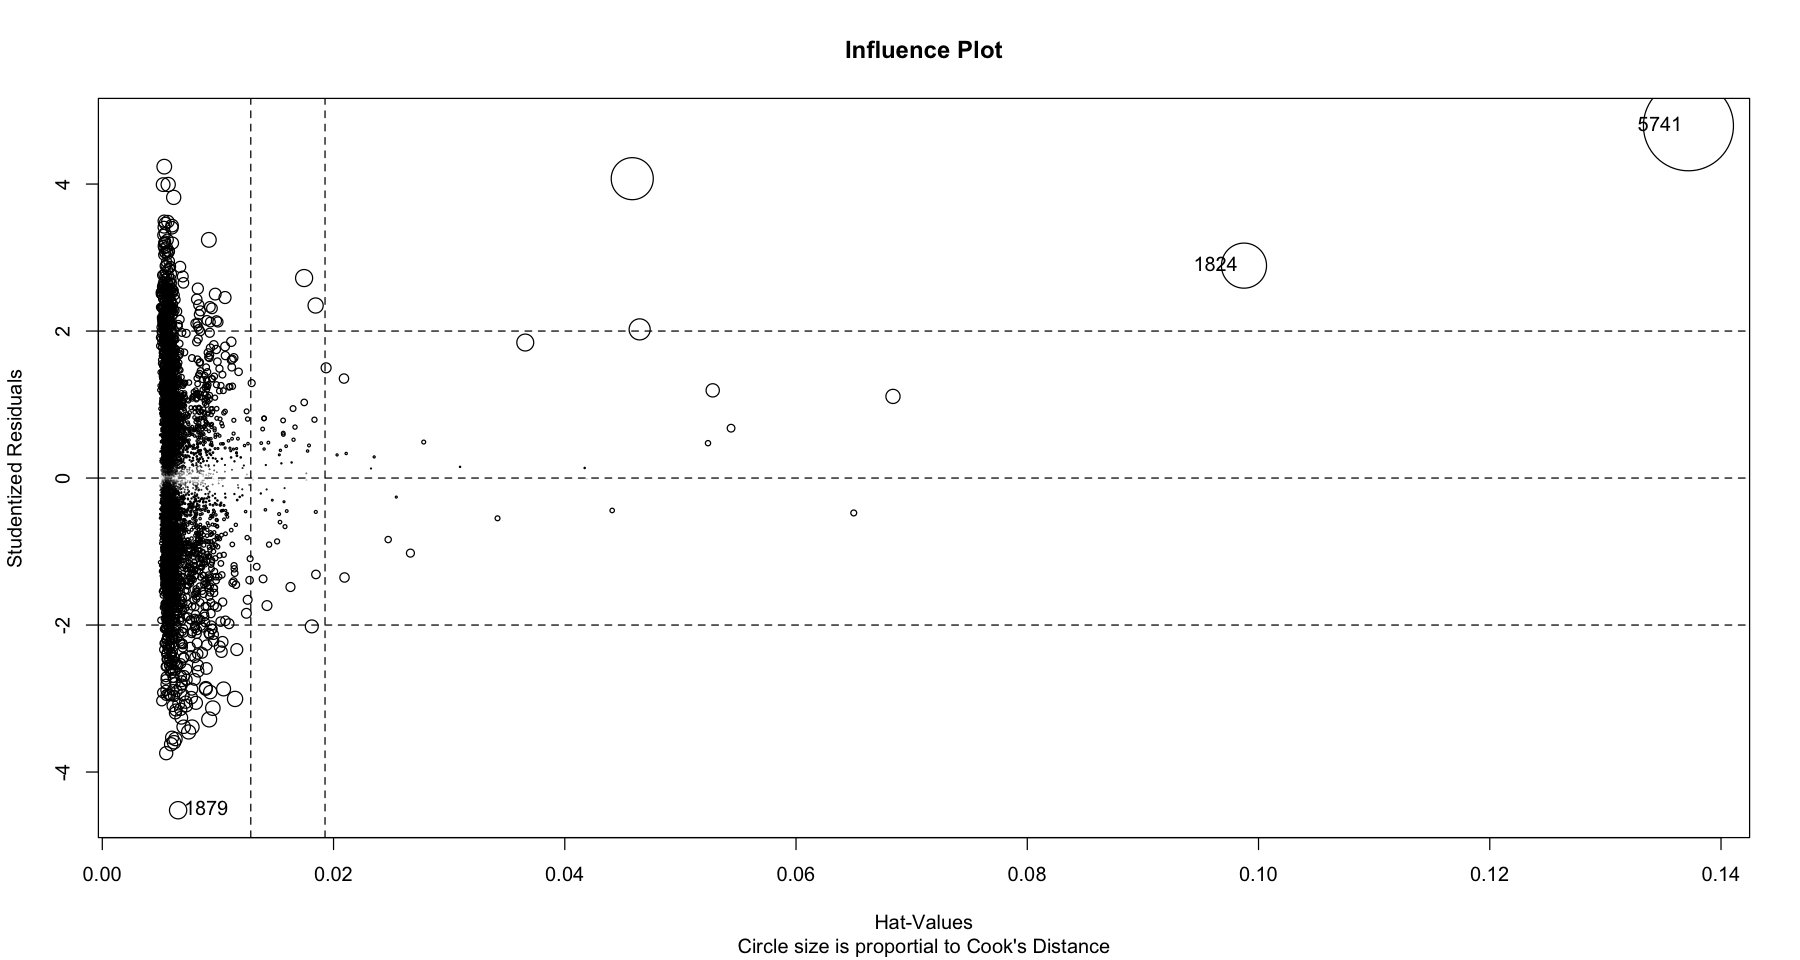

In [38]:
influence_pl = influencePlot(linear_fit3, scale=10, main="Influence Plot", sub="Circle size is proportial to Cook's Distance")

influence_pl

#### High Leverage points

In the graph below we can see whether observations are outliers, leverage points, or both outliers and leverage points. We have already found significant outliers in the outlier test above, so we will focus on leverage poitns here. As a rule of thumb, if an observation has a leverage statistic which greatly exceeds (p+1)/n, where p is the number of predictors and n the number of observations, then the observation might be a high leverage point (James, Witten, Hasti, Tibshirani 2013). Here p is 43 (taking into consideration all hours and months which are treated as separate predictors) and n is 7008. So (43+1)/7008 = 0.0063. We will see if our model improves if we remove all leverage points which exceed 0.007, which in this case are 50 observations. In addition, we will also remove the 3 influence points (which include the two outliers).

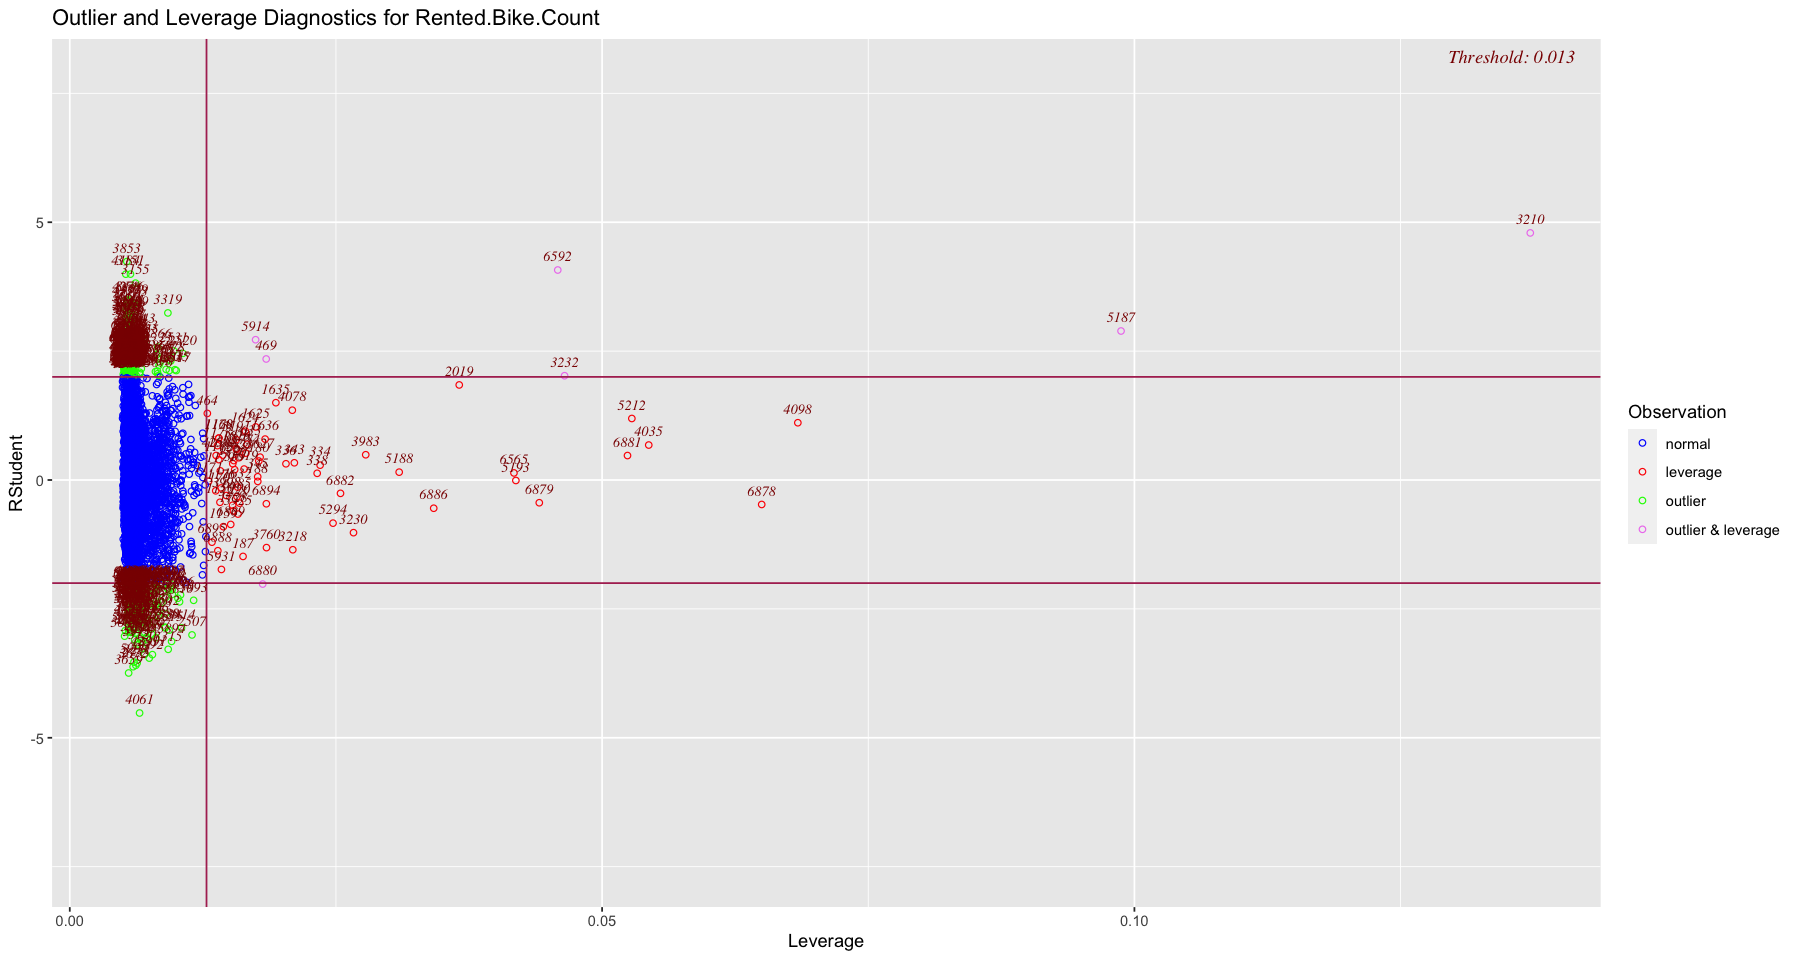

In [69]:
#install.packages('olsrr')
library(olsrr)

# creating outlier and leverage point diagnostics
ols_plot_resid_lev(linear_fit3,print_plot = TRUE)



In [40]:
# getting the points from the plot above as dataframe with the option 
# print_plot = FALSE

resid_lev = ols_plot_resid_lev(linear_fit3,print_plot = FALSE)

# getting dataframe, which is in index 2
resid_lev_df = as.data.frame(resid_lev[2])

# get the levarage points with leverage statistic greater than 0.008
high_lev_outl = subset(resid_lev_df, leverage.leverage > 0.008)

nrow(high_lev_outl)
head(high_lev_outl)

[1] 50

leverage.observation leverage.leverage leverage.stud_resid
597   597                 0.008201290       -2.245408          
1477 1477                 0.008013521       -2.439721          
1512 1512                 0.008540942       -2.011596          
2420 2420                 0.008161632       -2.120344          
2464 2464                 0.008714151       -2.033048          
2507 2507                 0.011482153       -3.005220

In [41]:
# creating function to remove influence and high leverage points
remove_points = function(infl_pl,df){
    indices = rownames(infl_pl)
    # check for the indices in the training dataset
    indices = which(rownames(df)%in%indices)
    return (df = df[-indices, ])
} 

In [42]:
#remove influential points/outliers from influence plot
bike_train5 = remove_points(influence_pl, bike_train3)
nrow(bike_train5)
#remove high leverage points
bike_train6 = remove_points(high_lev_outl, bike_train5)
nrow(bike_train6)

[1] 7005

[1] 6955

#### Lnear model with influeance points and high leverage points removed

In [43]:
linear_fit5 = lm(Rented.Bike.Count ~ ., data = bike_train6)
summary(linear_fit5)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train6)

Residuals:
     Min       1Q   Median       3Q      Max 
-1330.02  -215.21    -9.31   202.84  1615.74 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -490.77423   51.81601  -9.471  < 2e-16 ***
Hour.L              915.41252   24.28951  37.688  < 2e-16 ***
Hour.Q              251.16213   31.49310   7.975 1.77e-15 ***
Hour.C             -258.22461   24.97055 -10.341  < 2e-16 ***
Hour^4             -323.00079   25.47424 -12.680  < 2e-16 ***
Hour^5             -671.79688   22.54337 -29.800  < 2e-16 ***
Hour^6              239.08639   21.73114  11.002  < 2e-16 ***
Hour^7              462.96841   21.27934  21.757  < 2e-16 ***
Hour^8             -238.85075   20.88227 -11.438  < 2e-16 ***
Hour^9             -143.67907   20.81586  -6.902 5.57e-12 ***
Hour^10              73.26129   20.78950   3.524 0.000428 ***
Hour^11            -239.16222   20.87234 -11.458  < 2e-16 ***
Hour^12     

In [44]:
pred3 = predict(linear_fit5, test_data2)
test_label3 = test_data2[,1]

Metrics::rmse(actual = test_label3, 
                           predicted = pred3)

[1] 352.1994

Removing influence points and high leverage points had almost no influence on the model at all, so we will continue working on the previous model (linear_fit3).

#### Checking for multicollinearity

We have already discussed collinearity between two predictors in the correlation matrix and subsequently removed dew point temperature. However, the correlation matrix does not show us if there is collinearity between three or more predictors, which is referred to as multicollinearity. Multicollinearity can be just as problematic because it can reduce the accuracy of coefficient estimates.

We will inspect multilinearity with help of the variance inflation factor (VIF). VIFs with a score of more than 5 to 10 can be seen as potentially problematic (James, Witten, Hastie, Tibshirani 2013).

From the table below we can see that months and temperature have a very high GVIF. We will try to remove months and see whether the model improves.

In [67]:
#install.packages('caret')
library(tidyverse)
library(caret)

car::vif(linear_fit3)

GVIF      Df GVIF^(1/(2*Df))
Hour             5.258129 23 1.036741       
Temperature     11.162960  1 3.341102       
Humidity         3.110207  1 1.763578       
Wind.speed       1.437331  1 1.198888       
Visibility       2.321976  1 1.523803       
Solar.Radiation  4.645733  1 2.155396       
Rainfall         1.093112  1 1.045520       
Snowfall         1.139201  1 1.067334       
Holiday          1.045365  1 1.022431       
Functioning.Day  1.087266  1 1.042720       
Month           16.794511 11 1.136814       
Weekend          1.012234  1 1.006098

In [46]:
bike_train7 = bike_train3

bike_train7 = bike_train7[,-12]

head(bike_train7,2)

linear_fit6 = lm(Rented.Bike.Count ~ ., data = bike_train7)
summary(linear_fit6)


Rented.Bike.Count Hour Temperature Humidity Wind.speed Visibility
1002 254               0    -5.2        37       2.2        2000      
2071  78               4    -6.0        36       2.3        2000      
     Solar.Radiation Rainfall Snowfall Holiday    Functioning.Day Weekend
1002 0               0        0        No Holiday Yes             No     
2071 0               0        0        No Holiday Yes             No


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train7)

Residuals:
     Min       1Q   Median       3Q      Max 
-1407.48  -234.56     0.42   208.01  1757.46 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -3.322e+02  4.589e+01  -7.238 5.05e-13 ***
Hour.L              9.228e+02  2.543e+01  36.293  < 2e-16 ***
Hour.Q              3.146e+02  3.371e+01   9.333  < 2e-16 ***
Hour.C             -2.451e+02  2.603e+01  -9.416  < 2e-16 ***
Hour^4             -3.717e+02  2.755e+01 -13.493  < 2e-16 ***
Hour^5             -6.894e+02  2.434e+01 -28.327  < 2e-16 ***
Hour^6              2.485e+02  2.373e+01  10.472  < 2e-16 ***
Hour^7              4.744e+02  2.321e+01  20.439  < 2e-16 ***
Hour^8             -2.513e+02  2.281e+01 -11.014  < 2e-16 ***
Hour^9             -1.436e+02  2.275e+01  -6.310 2.96e-10 ***
Hour^10             7.573e+01  2.273e+01   3.332 0.000868 ***
Hour^11            -2.417e+02  2.283e+01 -10.585  < 2e-16 ***
Hour^12     

Now where we have removed months there are no problematic GVIF scores. We will check whether this has a positive influence when applying the model on the test data.

In [47]:
car::vif(linear_fit6)

GVIF     Df GVIF^(1/(2*Df))
Hour            4.335010 23 1.032399       
Temperature     1.818325  1 1.348453       
Humidity        2.718300  1 1.648727       
Wind.speed      1.385690  1 1.177153       
Visibility      1.585147  1 1.259026       
Solar.Radiation 4.448060  1 2.109042       
Rainfall        1.085504  1 1.041875       
Snowfall        1.098659  1 1.048169       
Holiday         1.007685  1 1.003835       
Functioning.Day 1.009825  1 1.004900       
Weekend         1.008203  1 1.004093

In [48]:
# briging test data into same format as train data
test= test_data2[,-c(12,13)]

pred4 = predict(linear_fit6, test)
test_label4 = test[,1]

Metrics::rmse(actual = test_label4 , predicted = pred4)

[1] 387.2614

Removing the month column has actually increased the RMSE, so the first model (linear_fit3) will be further developed.

#### Transformation

Next we will inspect whether the relationship between predictors and outcome can assumed to be linear. If this is the case, the points in the residual vs fitted plot should be randomly distributed across the horizontal line. We can see from the top left plot that this is not the case. In fact, there is quite a distinct pattern to see (a line going from the top left to the bottom right). So linearity cannot be assumed. 

The QQ plot shows us that the residuals are normally distributed, so there is no issue with the data in these regards. The scale-location indicates whether residuals are spread equally along the ranges of predictors. Again, e would expect the data points to be randomly distributed across a horizontal line. This in not the case for our data.

The fourth plot is a residual-leverage plot, which we have already discussed above.

Since a linear relationship cannot be assumed, we will try to transform some of the variables which have a distribution far from normal, to see whether this will improve our model.

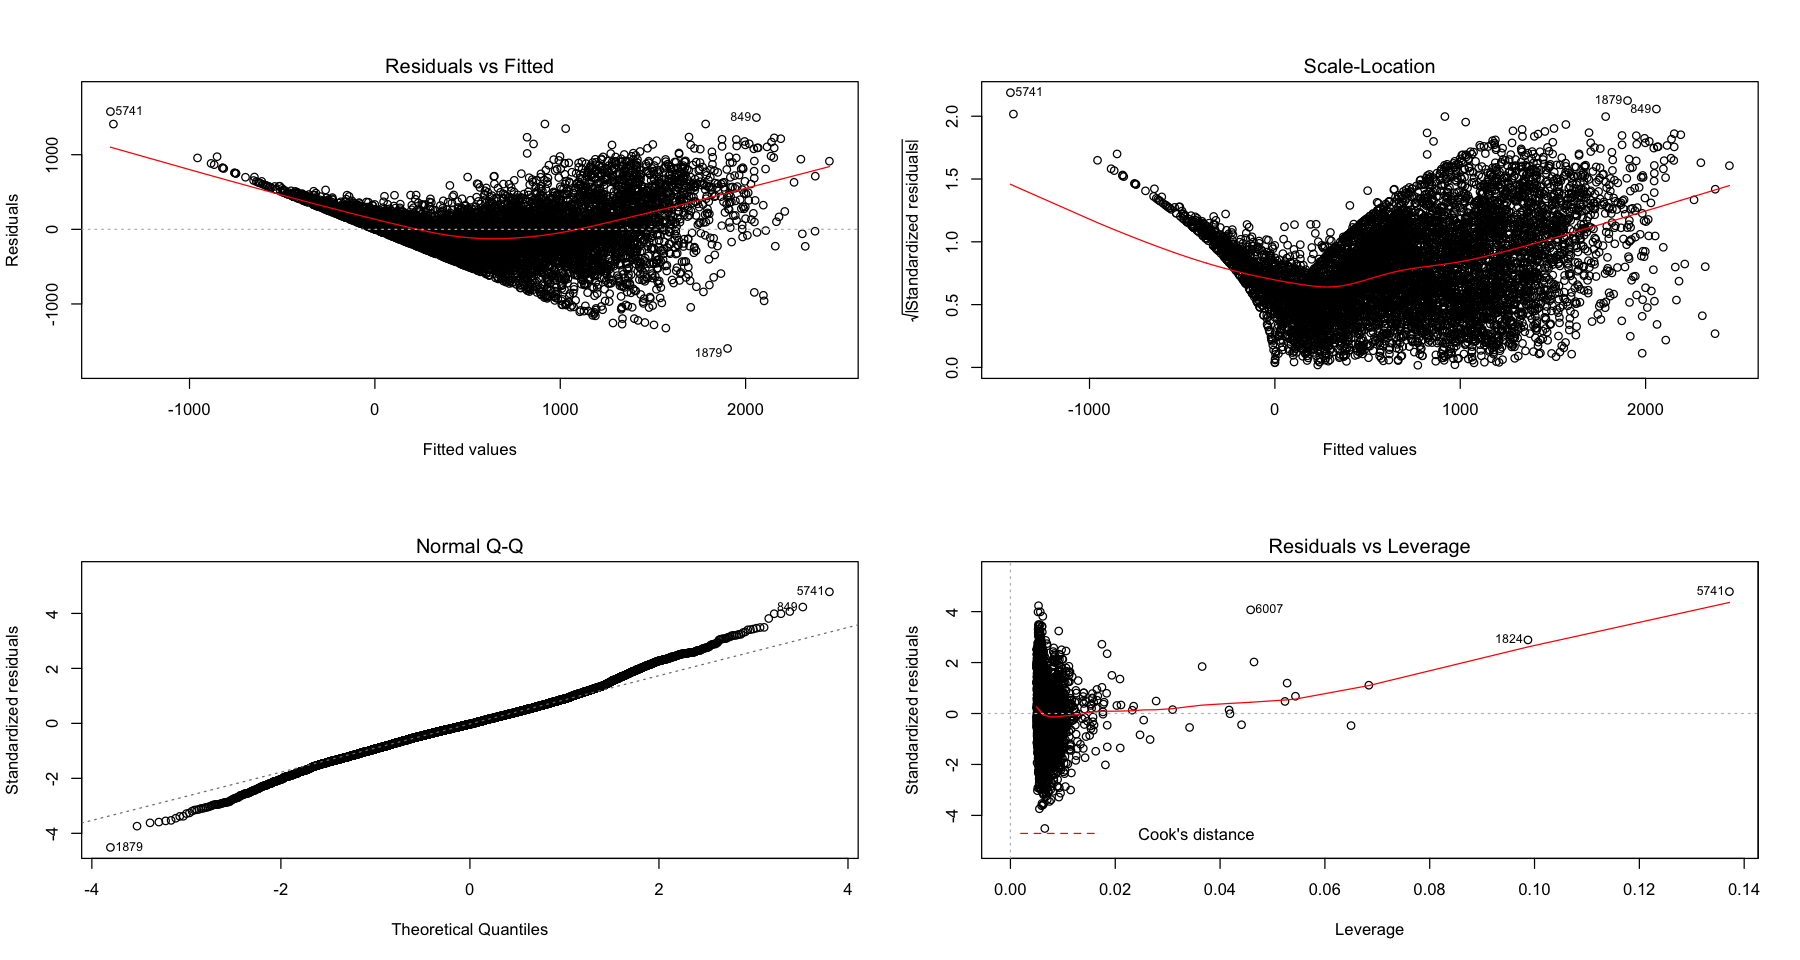

In [49]:
par(mfcol=c(2,2))
plot(linear_fit3)

When transforming Rented.Bike.Count, Visibility and Solar.Radiation our adjusted R-squared improves from roughly 70% to roughly 80%. 

In [50]:
bike_train8 = bike_train3

# applying cubic root tranformation

bike_train8$Rented.Bike.Count = (bike_train8$Rented.Bike.Count)^(1/3)
bike_train8$Visibility = (bike_train8$Visibility)^(1/3)
bike_train8$Solar.Radiation = (bike_train8$Solar.Radiation)^(1/3)
                               
linear_fit7 = lm(Rented.Bike.Count ~ ., data = bike_train8)
summary(linear_fit7)




Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train8)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7093 -0.7023  0.1058  0.8694 11.4825 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -3.547707   0.258205 -13.740  < 2e-16 ***
Hour.L              3.227206   0.097900  32.964  < 2e-16 ***
Hour.Q              3.109278   0.199404  15.593  < 2e-16 ***
Hour.C             -0.489622   0.107657  -4.548 5.51e-06 ***
Hour^4             -0.935188   0.117537  -7.957 2.05e-15 ***
Hour^5             -3.167388   0.087944 -36.016  < 2e-16 ***
Hour^6              0.649212   0.081954   7.922 2.71e-15 ***
Hour^7              1.848567   0.080565  22.945  < 2e-16 ***
Hour^8             -1.352229   0.079864 -16.932  < 2e-16 ***
Hour^9             -0.085283   0.082267  -1.037 0.299928    
Hour^10             0.647640   0.079814   8.114 5.73e-16 ***
Hour^11            -1.201309   0.080488 -14.925  < 2e-16 ***
Hour^12            -0.088266   0.08

However, when looking at the Residuals vs Fitted plot, we can see that the transformation did not make the linear assumption true. There is still a pattern in the plot. We will soon see whether the RMSE gets improved when running the model on the test data.

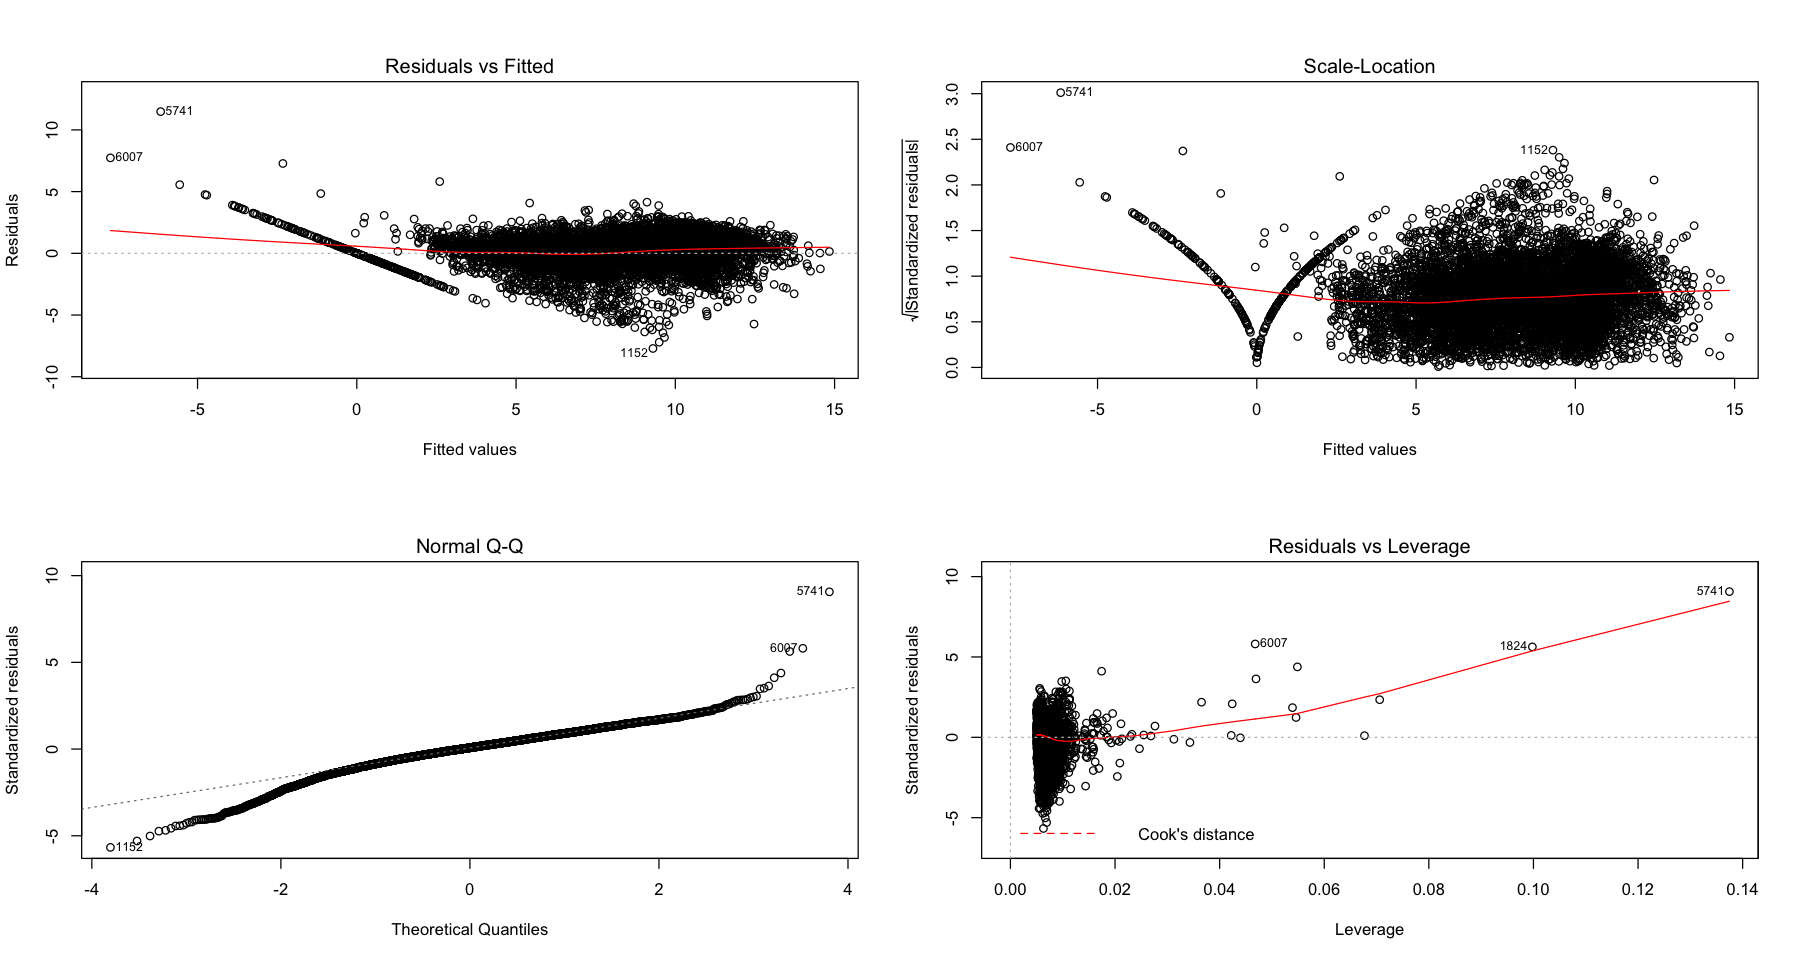

In [51]:
par(mfcol=c(2,2))
plot(linear_fit7)

#### Interaction

In a linear regression, regression coefficients tell us how much the outcome variable will change if we increase the specific predictor by one unit, and keep all other predictors constant. However, sometimes there is an interaction between predictors. That means that the effect of one predictor depends on the value of another predictor. One possible interaction might be between temperature and humidity. It could be that either high temperature or high humidity does not stop people from renting bikes, however, if they are both high, it might be unpleasant to go by bike.

This interaction will be performed below. When looking at the resulting model, the interaction term does not significantly change the adjusted R square. We will continue without the interaction term.

In [52]:
# Try interaction between temperature and humidity
linear_fit8 = summary(update(linear_fit7, . ~ . + Temperature:Humidity))

linear_fit8


Call:
lm(formula = Rented.Bike.Count ~ Hour + Temperature + Humidity + 
    Wind.speed + Visibility + Solar.Radiation + Rainfall + Snowfall + 
    Holiday + Functioning.Day + Month + Weekend + Temperature:Humidity, 
    data = bike_train8)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.6376 -0.7019  0.1109  0.8602 11.4008 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -3.665e+00  2.600e-01 -14.098  < 2e-16 ***
Hour.L                3.281e+00  9.891e-02  33.168  < 2e-16 ***
Hour.Q                2.974e+00  2.026e-01  14.679  < 2e-16 ***
Hour.C               -5.535e-01  1.090e-01  -5.078 3.90e-07 ***
Hour^4               -8.582e-01  1.193e-01  -7.193 7.01e-13 ***
Hour^5               -3.140e+00  8.818e-02 -35.613  < 2e-16 ***
Hour^6                6.191e-01  8.230e-02   7.522 6.05e-14 ***
Hour^7                1.857e+00  8.053e-02  23.063  < 2e-16 ***
Hour^8               -1.341e+00  7.986e-02 -16.791  < 2e-16 ***
Hour^9    

We can see that the transformation has quite significantly improved our model so we will keep the transformation terms.

In [53]:
test_data4 = test_data2

test_data4$Rented.Bike.Count = (test_data4$Rented.Bike.Count)^(1/3)
test_data4$Visibility = (test_data4$Visibility)^(1/3)
test_data4$Solar.Radiation = (test_data4$Solar.Radiation)^(1/3)

test_data4 = test_data4[,-12]

# head(test_data4)
# head(bike_train6)
pred5 = predict(linear_fit7, test_data4)^3
test_label5 = test_data4[,1]^3

Metrics::rmse(actual = test_label5 , predicted = pred5)

[1] 310.2821

#### Feature selection

As a last step in our linear regression analysis we will perform feature selection via a stepwise selection. Feature selection can be useful for model interpretability, as it occurs often that some predictors don't have much influence on the outcome and thus are not necessary.

After perfroming stepwise selection we can see that all variables are seen as being relevant except for Snowfall. As this is not a big change to our previous model, the previous model will be the final linear regression model with a RMSE of 310.28.

In [54]:
step_linear = step(linear_fit7)
summary(step_linear)

Start:  AIC=4392.57
Rented.Bike.Count ~ Hour + Temperature + Humidity + Wind.speed + 
    Visibility + Solar.Radiation + Rainfall + Snowfall + Holiday + 
    Functioning.Day + Month + Weekend

                  Df Sum of Sq   RSS     AIC
- Snowfall         1       1.0 12950  4391.1
<none>                         12949  4392.6
- Wind.speed       1      18.9 12968  4400.8
- Visibility       1     131.1 13080  4461.2
- Weekend          1     210.8 13160  4503.7
- Holiday          1     211.0 13160  4503.8
- Solar.Radiation  1     434.3 13383  4621.8
- Humidity         1     535.8 13485  4674.7
- Temperature      1    1243.1 14192  5033.0
- Rainfall         1    1248.5 14197  5035.7
- Month           11    3249.0 16198  5939.5
- Hour            23    9484.4 22433  8197.7
- Functioning.Day  1   18116.9 31066 10523.3

Step:  AIC=4391.14
Rented.Bike.Count ~ Hour + Temperature + Humidity + Wind.speed + 
    Visibility + Solar.Radiation + Rainfall + Holiday + Functioning.Day + 
    Month + Week


Call:
lm(formula = Rented.Bike.Count ~ Hour + Temperature + Humidity + 
    Wind.speed + Visibility + Solar.Radiation + Rainfall + Holiday + 
    Functioning.Day + Month + Weekend, data = bike_train8)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7067 -0.7024  0.1026  0.8705 11.4789 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -3.545875   0.258185 -13.734  < 2e-16 ***
Hour.L              3.225171   0.097860  32.957  < 2e-16 ***
Hour.Q              3.110358   0.199392  15.599  < 2e-16 ***
Hour.C             -0.487702   0.107623  -4.532 5.95e-06 ***
Hour^4             -0.936426   0.117522  -7.968 1.87e-15 ***
Hour^5             -3.168606   0.087926 -36.037  < 2e-16 ***
Hour^6              0.650337   0.081938   7.937 2.40e-15 ***
Hour^7              1.848646   0.080562  22.947  < 2e-16 ***
Hour^8             -1.352948   0.079856 -16.942  < 2e-16 ***
Hour^9             -0.085561   0.082263  -1.040 0.298337    
Hour^10           

### 5.2 Gradient Boosing Machine  <a class="anchor" id="sec_5_2"></a>

Next, we will develop a Gradient Boosting Machine. GBM works in a way that it makes weak learners stronger over many iterations. That means, it starts off with a not very strong model, learns from its errors and continously improves it.

To find the best parameters for the GBM a hyperparameter grid will be used, in order to try different parameter combinations for shrinkage (how quickly the model learns), interaction depth, the minimum number of observations in the terminal node of the tree and the bag fraction which adds a stochastic component to the gradient descent so that it does not get stuck in a local minimum (UC Business Analytics R Programming Guide).

We train the model with the original train data, with date componets added (Weekday, Month, etc.). We do not remove any outliers, as GBM can deal well with outliers and also because we could see that removing outliers did not really change anything in the linear regression.

In [55]:
#install.packages('gbm')
library(gbm)

# take original data with feature engineered date columns and take date out
gbm_test = test_data[,-1]
gbm_train = bike_train[,-1]

set.seed(1)

gbm_bike = gbm::gbm(Rented.Bike.Count ~., 
             data = gbm_train, 
             shrinkage = 0.01, #step-size reduction - how quickly the model learns
             interaction.depth = 3, 
             n.minobsinnode = 5, #the minimum number of observations in the terminal nodes of the trees
             n.trees = 5000, #total number of trees to fit
             cv.folds = 5 #number of cross validations
             )

Loaded gbm 2.1.8



Distribution not specified, assuming gaussian ...


From the graph below we can see that creating 5000 trees reduced the testing error the most. The black line represents the training bernoulli deviance and the green line represents the testing bernoulli deviance.

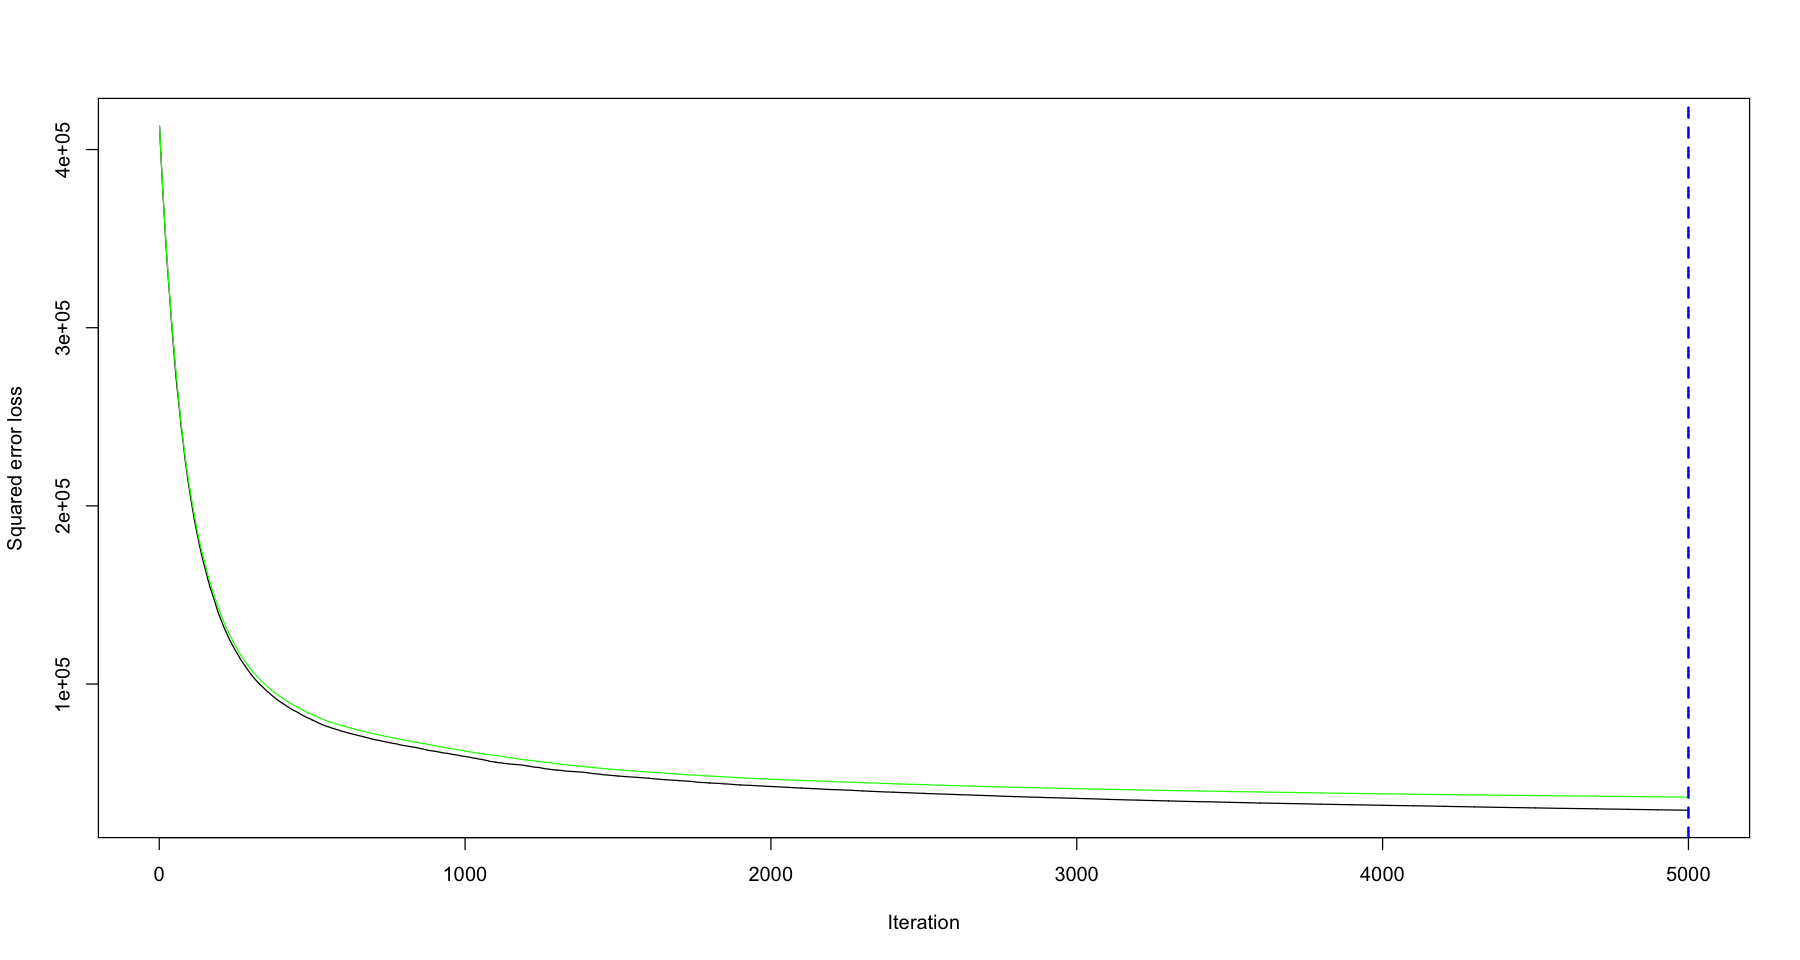

In [56]:
# model performance
gbm_performance = gbm.perf(gbm_bike, method = "cv")

We can see that the GBM works much better for our data than linear regression, which is no surprise as we could see that the linear assumption did not hold. The RMSE is almost half of the best linear regression model we have developed.

In [57]:
#applying model to test data
gbm_prediction = stats::predict(
                          object = gbm_bike, 
                          newdata = gbm_test,
                          n.trees = gbm_performance)

Metrics::rmse(actual = gbm_test[,1], predicted = gbm_prediction)



[1] 193.5201

In order to see whether we can further improve the model, we implement the hyperparameter grid as discussed above. Of course it would be even better to put more options into the grid, but by just giving one more option per parameter, 81 different models would need to be tested ($3^{4}$). For the purpose of this assignment, I will only go with 16 combinations ($2^{4}$). Further, these 16 combinations are only validated with a hold out set (75% for training, 25% hold out set). Cross-validation would be better, but also takes much more time to run.

In [58]:
# hyperparameter grid
hyper_grid = expand.grid(
  shrinkage = c(.01, .1),
  interaction.depth = c(3, 5),
  n.minobsinnode = c(5, 7),
  bag.fraction = c(.65, 1), 
  optimal_trees = 0, #initialization              
  min_RMSE = 0 #initialization                   
)

# total number of combinations
nrow(hyper_grid)


[1] 16

The top 10 hyperparameter combinations are shown in the table below. We will now run the GBM with the best parameter combination which as a shrinkage factor of 0.1, interaction depth of 5, 5 observations in the terminal node of the tree and a bagging fraction of 0.65.

In [59]:
# reproducibility
  set.seed(1)

#put dataframe in random order row wise
random_train = gbm_train[sample(nrow(gbm_train)),]

# grid search 
for(i in 1:nrow(hyper_grid)) {

  
  # train model
  gbm_grid = gbm(
    formula = Rented.Bike.Count ~ .,
    distribution = "gaussian",
    data = random_train,
    n.trees = 5000,
    interaction.depth = hyper_grid$interaction.depth[i],
    shrinkage = hyper_grid$shrinkage[i],
    n.minobsinnode = hyper_grid$n.minobsinnode[i],
    bag.fraction = hyper_grid$bag.fraction[i],
    train.fraction = .75,
    n.cores = NULL, 
    verbose = FALSE
  )
  
  # add min training error and trees to grid
  hyper_grid$optimal_trees[i] = which.min(gbm_grid$valid.error)
  hyper_grid$min_RMSE[i] = sqrt(min(gbm_grid$valid.error))
}

hyper_grid %>% 
  dplyr::arrange(min_RMSE) %>%
  head(10)

shrinkage interaction.depth n.minobsinnode bag.fraction optimal_trees
1  0.10      5                 5              0.65         4677         
2  0.10      5                 7              0.65         4999         
3  0.10      5                 5              1.00         4779         
4  0.10      5                 7              1.00         4929         
5  0.10      3                 7              1.00         4738         
6  0.10      3                 7              0.65         5000         
7  0.10      3                 5              0.65         4982         
8  0.10      3                 5              1.00         4905         
9  0.01      5                 7              0.65         5000         
10 0.01      5                 5              0.65         4995         
   min_RMSE
1  143.2191
2  143.3511
3  144.3278
4  147.3516
5  156.7877
6  156.8483
7  157.0774
8  158.9277
9  158.9573
10 159.4794

From the outcome below we can see that the parameters found by our hyperparameter grid have drastically improved the RMSE, from around 193.52 to around 148.44. 

Distribution not specified, assuming gaussian ...


[1] 148.4395

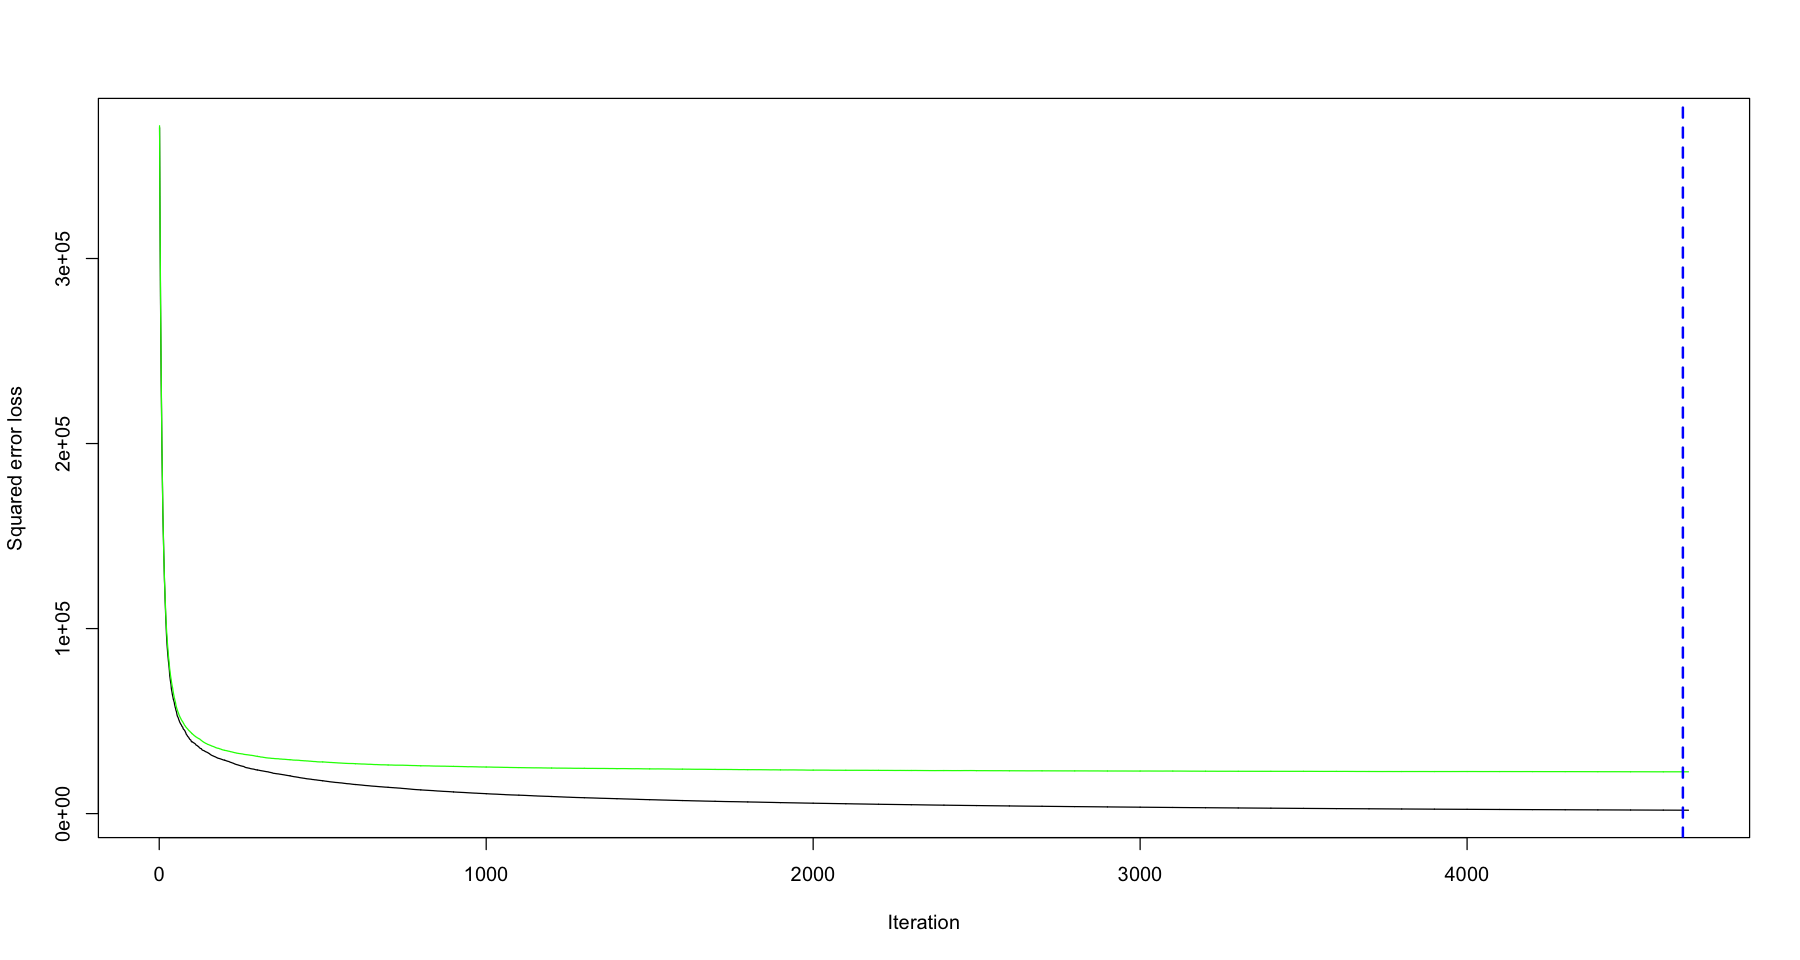

In [60]:
set.seed(1)

gbm_bike2 = gbm::gbm(Rented.Bike.Count ~., 
             data = gbm_train, 
             shrinkage = 0.1, #step-size reduction - how quickly the model learns
             interaction.depth = 5, 
             n.minobsinnode = 5, #the minimum number of observations in the terminal nodes of the trees
             n.trees = 4677, #total number of trees to fit
             cv.folds = 5,  #number of cross validations
            bag.fraction = 0.65
             )

gbm_performance2 = gbm.perf(gbm_bike2, method = "cv")

gbm_prediction2 = stats::predict(
                          object = gbm_bike2, 
                          newdata = gbm_test,
                          n.trees = gbm_performance2)

Metrics::rmse(actual = gbm_test[,1], predicted = gbm_prediction2)

### 5.3 Random Forest  <a class="anchor" id="sec_5_3"></a>

We will have a look at how well Random Forest performs for out data set. Random Forest works by creating many decision trees from subsets of the training data, and then predicting the outcome as the average of all predictions of the decision trees. We will here train the Random Forest with 10 features per subset of the data because it has the best performance after trying some different parameter values.

The random forest will not be fine-tuned, but is rather used as part of the inference task. Just as in GBM we won't remove outliers. 

We can see that, even though we don't fine tune the random forest it gives us very good results compared to linear regression. It is not as good as the fine-tuned GBM but has a very similar RMSE as the first GBM we created.

In [66]:
#install.packages('randomForest')
library(randomForest)

# reproducibility
set.seed(1)

# take original data with feature engineered date columns and take date out
rf_test = test_data[,-1]
rf_train = bike_train[,-1]

rf_bike = randomForest(Rented.Bike.Count ~., rf_train, mtry=10)
rf_predict = predict(rf_bike, rf_test)
rf_label = rf_test[,1]

Metrics::rmse(actual = rf_label, predicted = rf_predict)

[1] 169.0448

## 6. Inference <a class="anchor" id="sec_6"></a>

We will now discuss which of the predictors seem to be the most relevant in predicting the outcome. This is referred to as inference.
For that we will talk again about the **correlation matrix**, about the **p-values** of the predictors of our final linear regression model, about the outcome of the **stepwise selection** as well as which predictors are the most relevant for our **Random Forest** and our **Gradient Boosting Machine**.

#### Correlation matrix

In the correlation matrix we had a look at numerical features, and we could see that Rented Bike Count has a moderate positive correlation with Temperature. This means that temperature has at least a moderate influence on the number of bikes rented. More bikes are rented as the temperature increases. We could also see a weak positive correlation between Rented Bike Count and Dew Point Temperature. However, since Temperature and Dew Point Temperature are strongly correlated, we removed Dew Point temperature from the data. There were no further noteworthy correlations observed between Rented Bike Count and other features. We did not get any information regarding quanlitative features from the correlation matrix. We will talk about them when looking at p-values.


#### p-values

The p-values for each variable tell us how statistically significant the variable is for the outcome. When the p-value is below a certain threshold (often around 5%) we can reject the null hypothesis that there is no relationship between the variable and the outcome. 

In our final linear regression model (linear_fit7), which summary is shown below, we can see that the only variables which do not have very small p-values are some hours, some months and snowfall. However, overall months and hour are very significant according to the p-values. So overall, only snowfall does not seem to be very significant for the outcome.

In [62]:
summary(linear_fit7)


Call:
lm(formula = Rented.Bike.Count ~ ., data = bike_train8)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7093 -0.7023  0.1058  0.8694 11.4825 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -3.547707   0.258205 -13.740  < 2e-16 ***
Hour.L              3.227206   0.097900  32.964  < 2e-16 ***
Hour.Q              3.109278   0.199404  15.593  < 2e-16 ***
Hour.C             -0.489622   0.107657  -4.548 5.51e-06 ***
Hour^4             -0.935188   0.117537  -7.957 2.05e-15 ***
Hour^5             -3.167388   0.087944 -36.016  < 2e-16 ***
Hour^6              0.649212   0.081954   7.922 2.71e-15 ***
Hour^7              1.848567   0.080565  22.945  < 2e-16 ***
Hour^8             -1.352229   0.079864 -16.932  < 2e-16 ***
Hour^9             -0.085283   0.082267  -1.037 0.299928    
Hour^10             0.647640   0.079814   8.114 5.73e-16 ***
Hour^11            -1.201309   0.080488 -14.925  < 2e-16 ***
Hour^12            -0.088266   0.08

#### Stepwise selection

The stepwise selection returned all variables except for snowfall. This aligns with our observation from above in regards to p-values.

#### Gradient Boosting Machine and Random Forest 

We will now have a look which variables were the most important overall for our random forest and our GBM. 

The graph below shows that the most important variables for the the GBM are **hour**, **temperature** and **month**, followed by **functioning day** and **humidity**. This comes as now surprise as we could already see in our EDA that there were very clear trends for the hour in terms of the number of bikes rented, and the correlation matrix indicates a moderate positive relationship between bike rentals and temperature. The least important is again snowfall.

When looking at the importance of variables for our Randwom Forrest, the same can be observed. Hour, temperature and month, followed by functioning day and humidity are the most important features, and snowfall the least important. Only the variables of medium importance have a sligh different order compared to the GBM.

var                   rel.inf    
Hour                  Hour                  29.41527130
Temperature           Temperature           24.39559817
Month                 Month                  9.52991864
Functioning.Day       Functioning.Day        8.44658449
Humidity              Humidity               7.92763230
Solar.Radiation       Solar.Radiation        6.76305882
Weekday               Weekday                4.43445975
Rainfall              Rainfall               4.40378593
Dew.point.temperature Dew.point.temperature  1.72559615
Visibility            Visibility             1.11224533
Wind.speed            Wind.speed             0.89193673
Holiday               Holiday                0.48240742
Weekend               Weekend                0.32273375
Seasons               Seasons                0.09408054
Snowfall              Snowfall               0.05469068

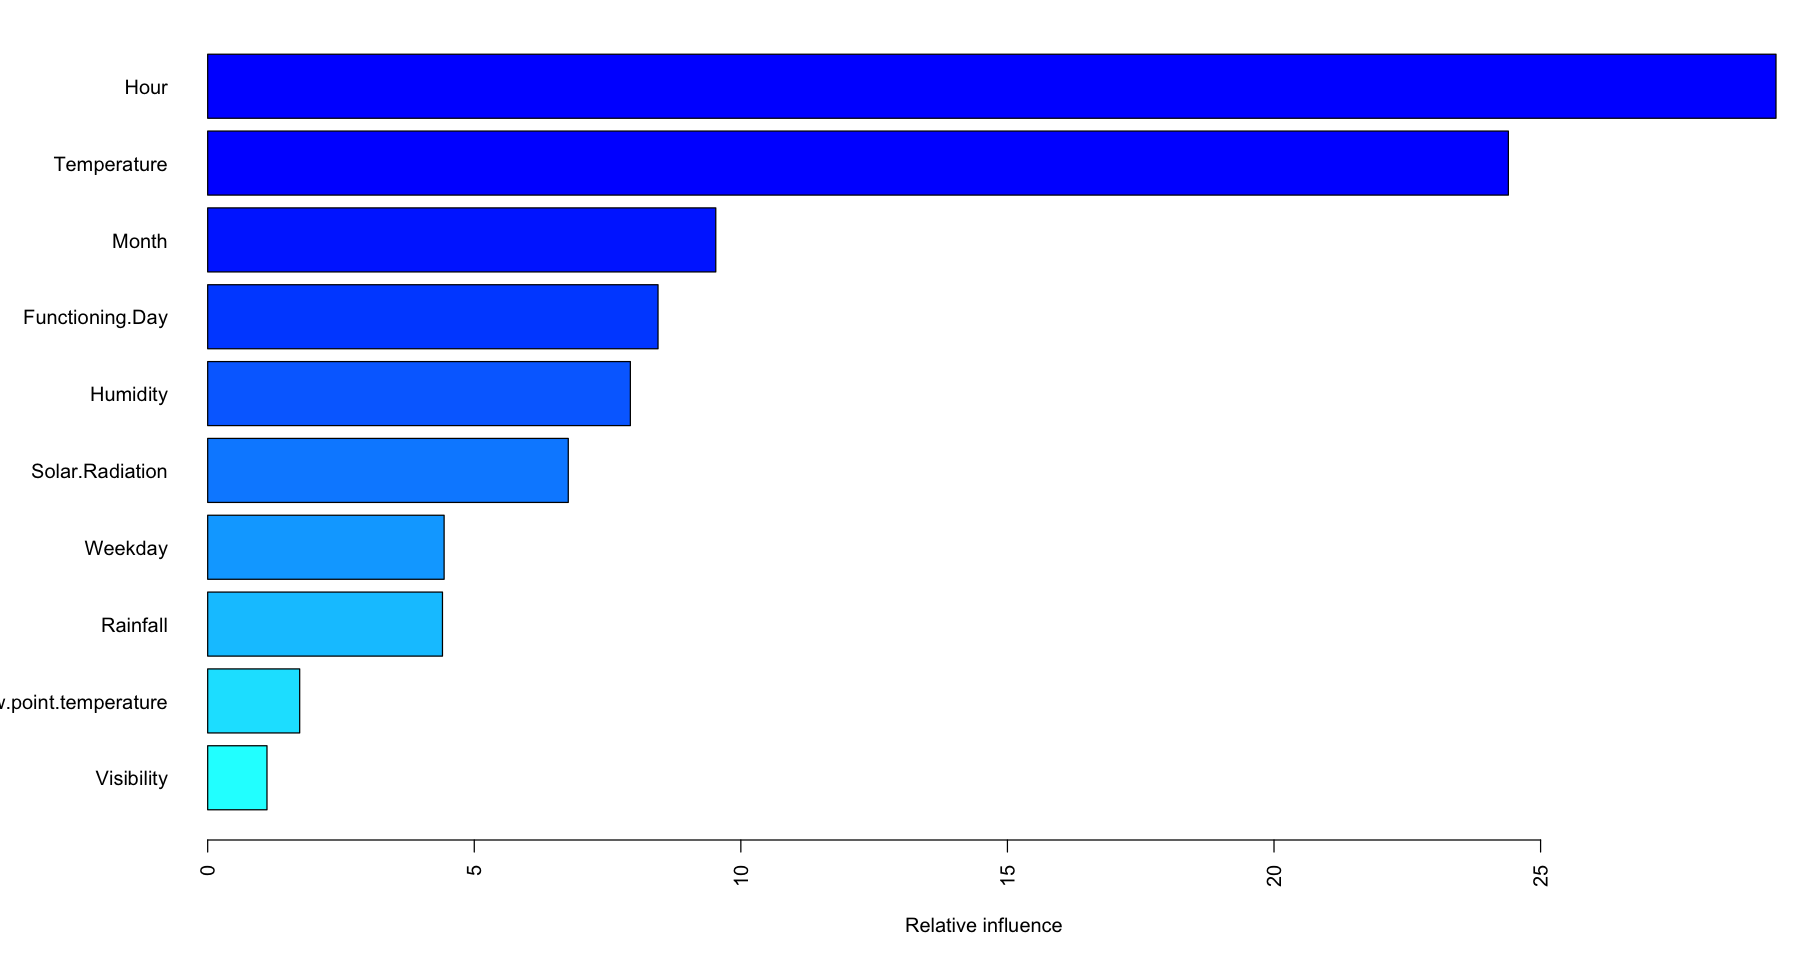

In [63]:
par(mar = c(5, 8, 1, 1))
summary(gbm_bike2, cBars = 10, las = 2)

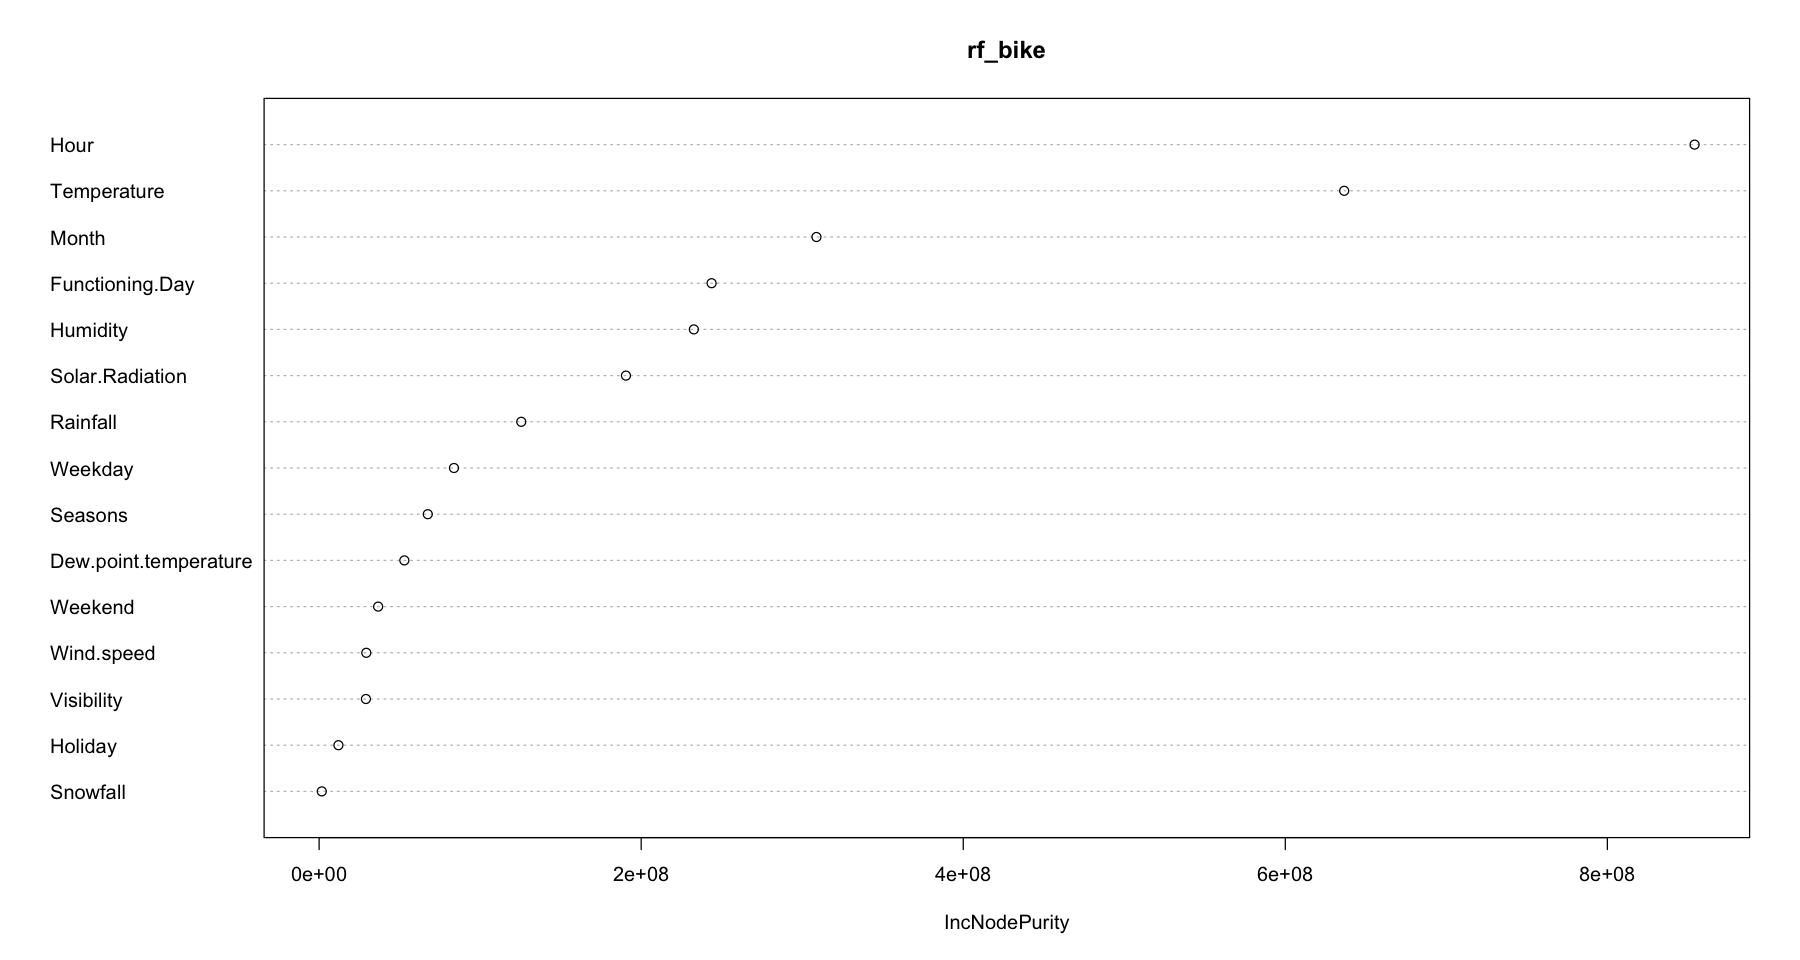

In [64]:
varImpPlot(rf_bike)

In [65]:
# revert supress warnings
options(warn = defaultW)

## 7. Results and discussion <a class="anchor" id="sec_7"></a>

We have tried three different types of models in order to predicted the rented bike count for a given hour: Multiple linear regression, Gradient Boosting Machine and Random Forest. For multiple linear regression we have used many different methods to improve the model: Changing the hour and months to ordered factors, removing variables with multicollinearity or low relevance, removing outliers and high leverage points and transformation and stepwise selection. While our linear model improved a lot (from a RMSE of above 400 to roughly 310 in the last model), there is only so much we can do if the actual relationship between predictors and outcome is non-linear, as is the case with our data. The advantage of using linear regression over the other two models in the interpretability though. 

Gradient Boosting Machine and Random Forrest returned much better results, even without fine tuning than our best linear model did. Choosing the best parameters with a hyperparameter grid significantly increased the performance of our model, with a final RMSE of 148.44. It is likely to find an even better fit for the GBM if we give more options to our hyperparameter grid, which was not done here because of computational constraints. The other advantage of using GBM and Random Forest over linear regression is that the former ones are less sensitive to outliers and missing values.

## 8. Conclusion<a class="anchor" id="sec_8"></a>

Our analysis has shown that the underlying relationship between predictors and outcome is of non-linear nature and thus, multiple linear regression is not a very suitable model for this type of data. 

GBM and Random Forest provided much better predictions, with the RMSE of the final model being less than half of the final linear regression model.

In terms of inferrence we learned that Hour and Temperature seem to be the most significant features in order to predicted the rented bike count, follwed by months, functioning day and humidity. Snowfall seems to be the least significant feature.

## 9. References <a class="anchor" id="sec_9"></a>

- Chandler, N. (2001). *What Is Relative Humidity and How Does it Affect How I Feel Outside?* Retrieved from https://science.howstuffworks.com/nature/climate-weather/atmospheric/question651.htm  

- James, G., Witten, D., Hastie, T., Tibshirani, R. (2013). *An Introduction to Statistical Learning with Applications in R*. DOI 10.1007/978-1-4614-7138-7

- jruf003. (2017). *Interpreting Alias table testing multicollinearity of model in R*. Retrieved from https://stackoverflow.com/questions/45328783/interpreting-alias-table-testing-multicollinearity-of-model-in-r/45971359

- Kaleko. (2017). *Feature Engineering - Handling Cyclical Features*. Retrieved from http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

- Spangler, P. (2019). *How to model with gradient boosting machine in R* Retrieved from https://www.storybench.org/tidytuesday-bike-rentals-part-2-modeling-with-gradient-boosting-machine/

- UC Business Analytics R Programming Guide. *Gradient Boosting Machines* Retrieved from http://uc-r.github.io/gbm_regression

- user20650. (2018). *ggpairs plot with heatmap of correlation values*. Retrieved from https://stackoverflow.com/questions/45873483/ggpairs-plot-with-heatmap-of-correlation-values/45882326